# Lesson 4 Boosting Machines

You are probably wandering why we are not going to go deep on GLM, SVMs, and other models. Decision Trees combined with ensembling (RF and GBM) are world class algorithms and they do not really care about data-preprocessing as we have seen. On the contrary, SVMs and its variants tend to perform similar to tree-based algorithms but need a very specific preprocessing of the data and much more mathematical background. Its advantatge is that they extrapolate better.

The topics we are going to see during this lesson are:
* More Glossary concepts?
    - Clustering
    - Word Embedding
    - One Hot Embedding
    - Gradient (partial derivatives)
    - Optimization techniques
    - Back-prop
    
* Gradient Descent review
* Gradient Boosting Machines (tree based) from scratch 
* Tips and tricks for boosting

* Using SKLearn
* How they perform on our `adults` dataset
* Using `xgboost`

## Gradient Descent review
https://en.wikipedia.org/wiki/Gradient_descent



In [1]:
import numpy as np

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)
from plots import *

In [3]:
x = np.linspace(0,10,100)
y = np.sin(x)#+np.random.rand(len(x))*.5
reg_plot(x,y,[],[])

In [4]:
## type hinting
def grad_desc(x: np.ndarray, y: np.ndarray, curr: np.ndarray, lr: float, max_iter: int) -> np.ndarray:
    track = []
    for i in range(max_iter):
        id_min = np.argmin(np.abs(curr-x))
        numerical_derivative = ((y[id_min+1]-y[id_min])/(x[id_min+1]-x[id_min]))
        curr = curr - lr * numerical_derivative
        track.append(id_min)
    return track,curr

In [5]:
track,final = grad_desc(x,y,curr=2,lr=.1,max_iter=120)

In [6]:
x[track][:10]

array([2.02020202, 2.02020202, 2.12121212, 2.12121212, 2.22222222,
       2.32323232, 2.32323232, 2.42424242, 2.52525253, 2.62626263])

In [7]:
reg_plot(x,y,[[x[track],y[track]]],["grad_desc"])

But how can we use our gradient descent for ML? Well, MSE is a convex function w.r.t the parameters?
$$MSE(x,y) = \frac{1}{n}\sum_{i=1}^{n}\Big(f(x,\widehat{\theta})-y\Big)^2$$

In [8]:
x = np.linspace(0,10,100)
noise = np.random.rand(len(x))*20 - 10
y = 3*x + 4 + noise
reg_plot(x,y,[],[])

In [9]:
def mse(preds,labels):
    return (np.square(preds - labels)).mean()

def model(x,a,b):
    return a*x+b*1

Now we are going to do a grid search on MSE to find the minimum.

In [10]:
params_grid = 100*np.random.rand(10000,2)-50;params_grid

array([[ 45.48569544, -35.4989703 ],
       [-47.88362843,   3.92547333],
       [ 47.30119034,  30.33214922],
       ...,
       [-27.411643  ,  38.72195394],
       [ -3.82673518,  16.70963165],
       [-26.83517335,  41.09277329]])

In [11]:
obj = []
for i in range(len(params_grid)):
    obj.append(mse(model(x,params_grid[i,0],params_grid[i,1]),y))
obj = np.array(obj).reshape(-1,1)

In [12]:
np.concatenate([params_grid,obj],axis=1)

array([[ 4.54856954e+01, -3.54989703e+01,  4.56635542e+04],
       [-4.78836284e+01,  3.92547333e+00,  8.62645519e+04],
       [ 4.73011903e+01,  3.03321492e+01,  7.86661953e+04],
       ...,
       [-2.74116430e+01,  3.87219539e+01,  2.14021407e+04],
       [-3.82673518e+00,  1.67096317e+01,  8.38010216e+02],
       [-2.68351734e+01,  4.10927733e+01,  1.99123641e+04]])

In [13]:
data = [
    go.Scatter3d(
        x=params_grid[:,0],
        y=params_grid[:,1],
        z=obj[:,0],
        mode='markers',
        marker=dict(
            size=2,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        )
    )
]
layout = go.Layout(
    title='MSE of a line'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['ggplot'])

array([2.85142035, 3.23281543])

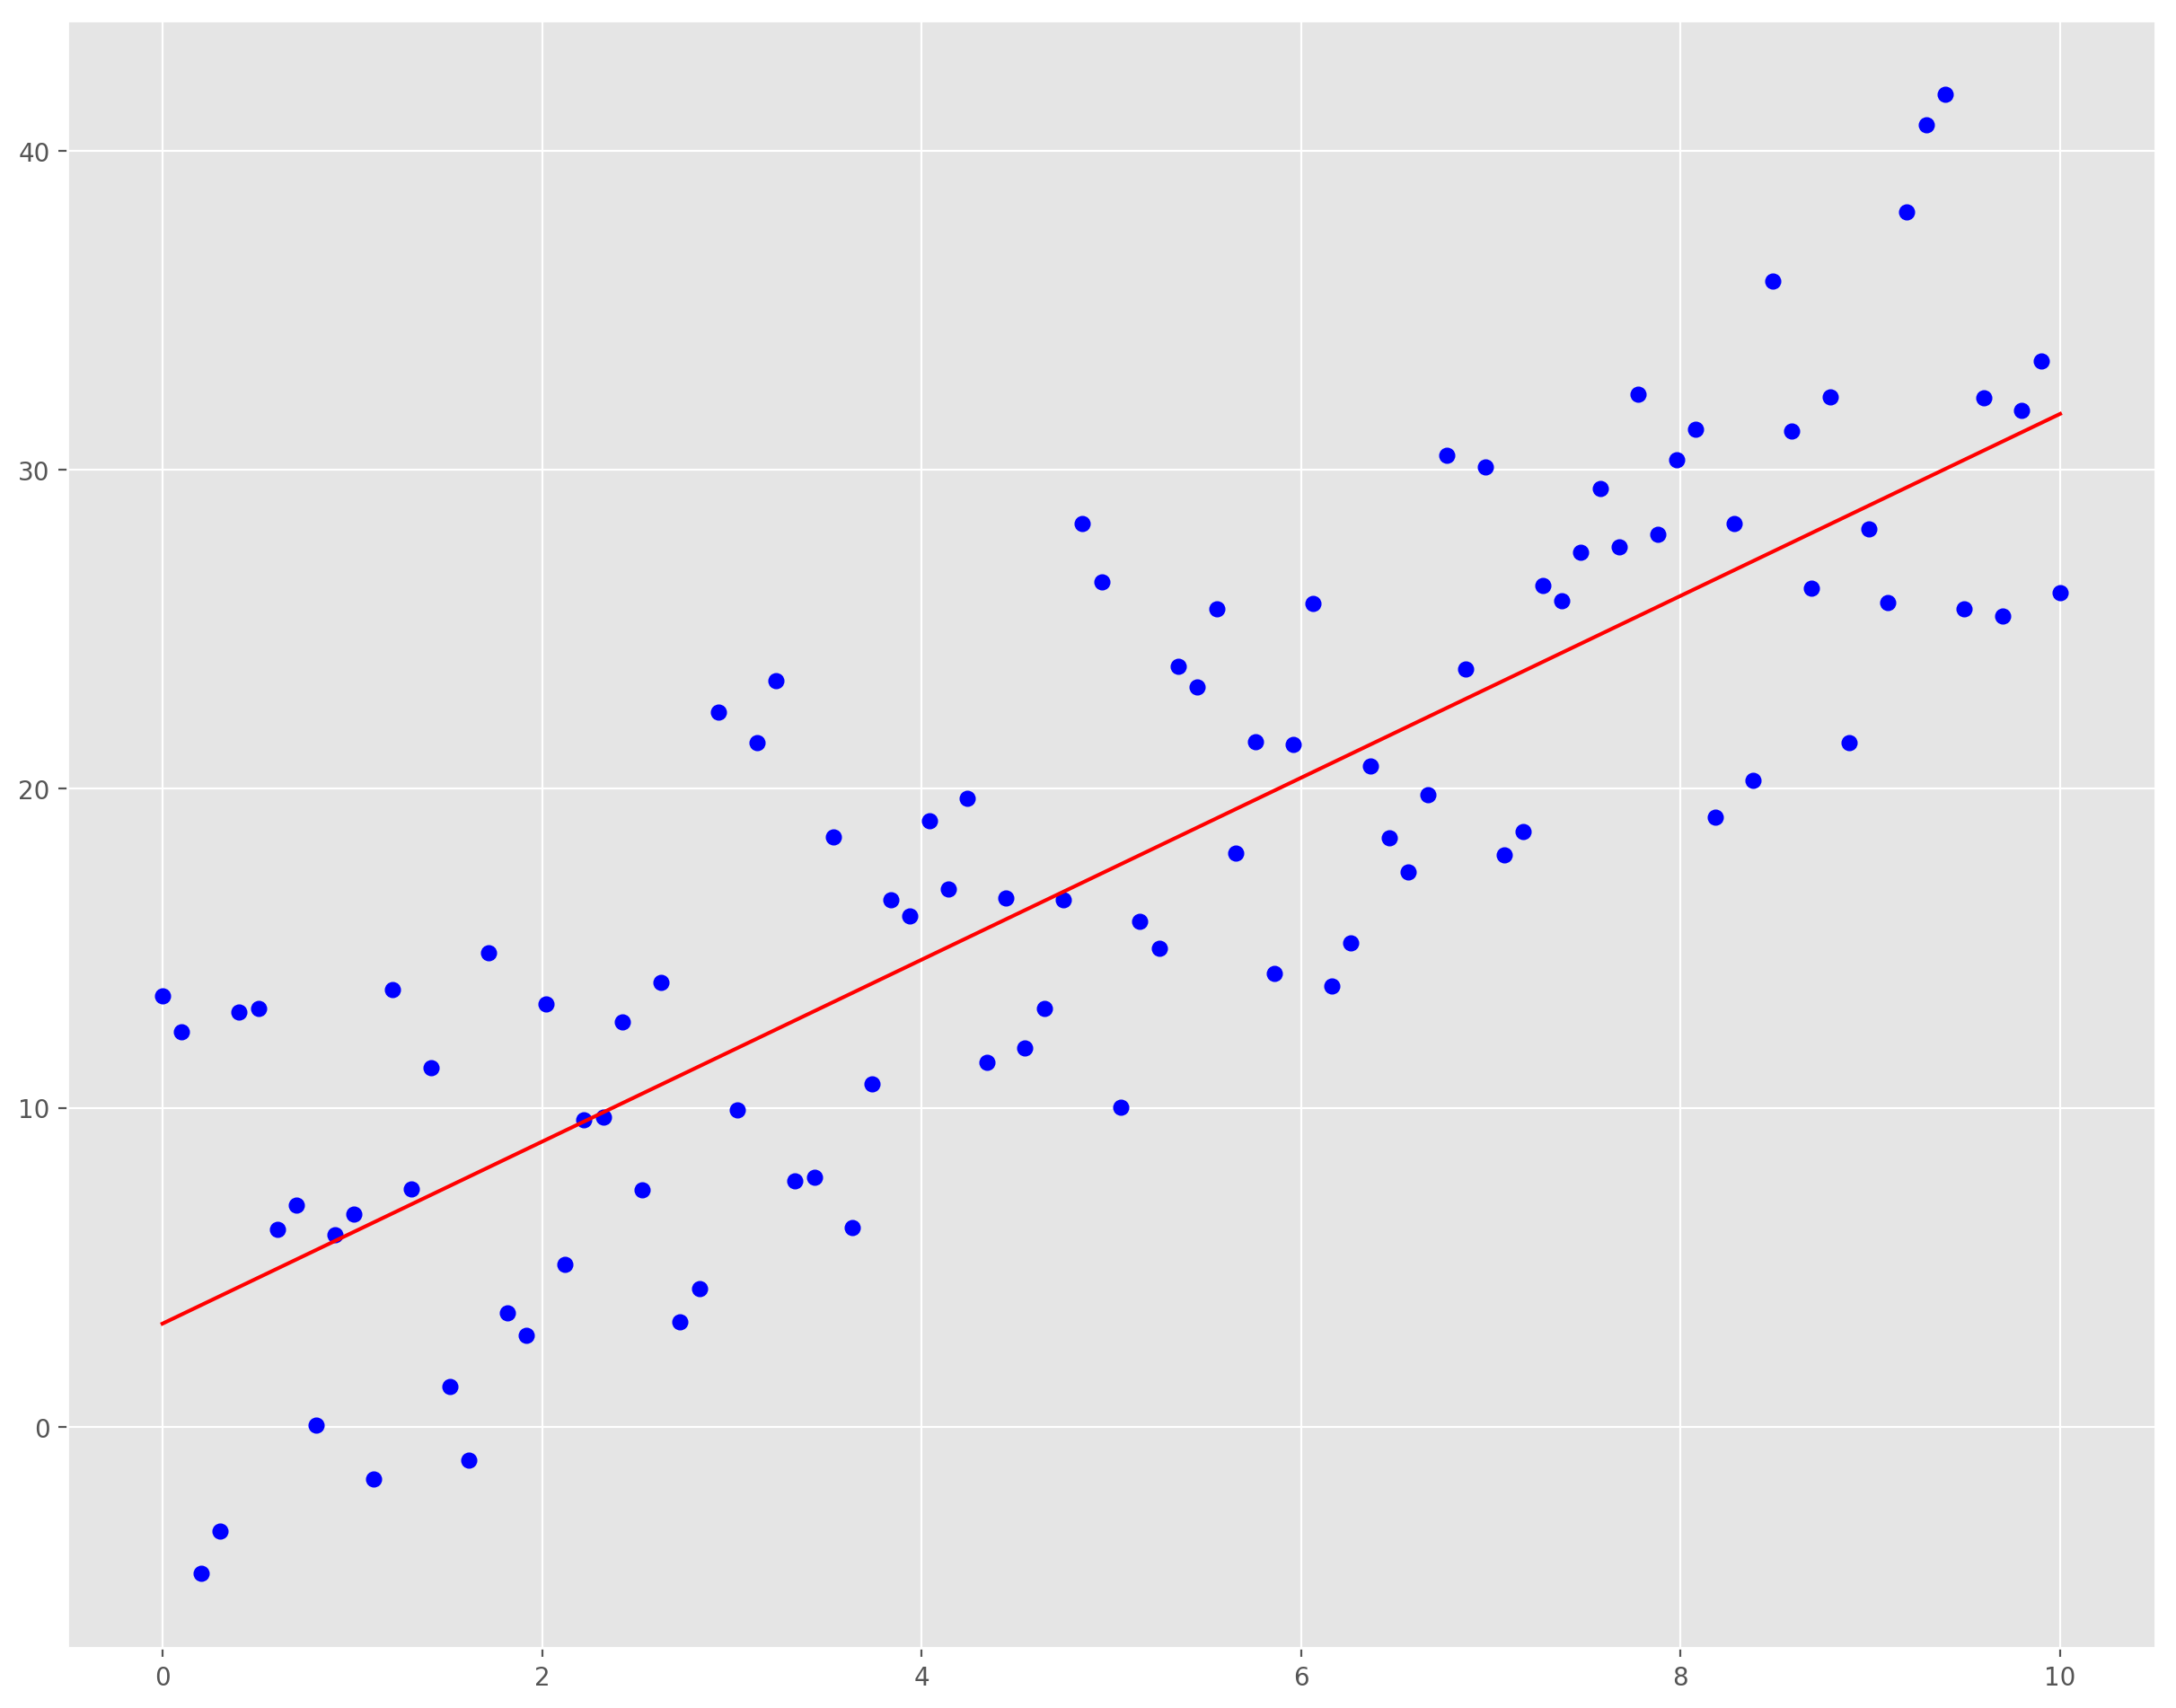

In [15]:
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(x,y,c="b")
plt.plot(x,params_grid[np.argmin(obj),:][0]*x+params_grid[np.argmin(obj),:][1],c="r");params_grid[np.argmin(obj),:]

Now we will find the minimum using the gradient descent. Note that this technique tends to the classical result obtained in lesson 2 when we were doing linear regression model (basically we are using the proof iteratively).

In [16]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100):
    '''
    X    = Matrix of X with added bias units
    y    = Vector of Y
    theta=Vector of thetas np.random.randn(j,1)
    learning_rate 
    iterations = no of iterations
    
    Returns the final theta vector and array of cost history over no of iterations
    '''
    m = len(y)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,2))
    for it in range(iterations):
        
        prediction = np.sum(X*theta,axis=1)
        theta = theta -(1/m)*learning_rate*( X.T.dot((prediction - y)))
        theta_history[it,:] =theta
        cost_history[it]  = mse(np.sum(X*theta,axis=1),y)
        
    return theta, cost_history, theta_history

In [17]:
theta,ch,th = gradient_descent(X=np.concatenate([x.reshape(-1,1),np.ones(len(x)).reshape(-1,1)],axis=1),
                               y=y,
                               theta=np.random.randn(2)-100,
                               learning_rate=1e-2,
                               iterations=10000
                              )

In [18]:
theta

array([2.92523645, 3.4280764 ])

In [19]:
ch[-1],mse(params_grid[np.argmin(obj),:][0]*x+params_grid[np.argmin(obj),:][1],y)

(31.065050429006824, 31.429855787005163)

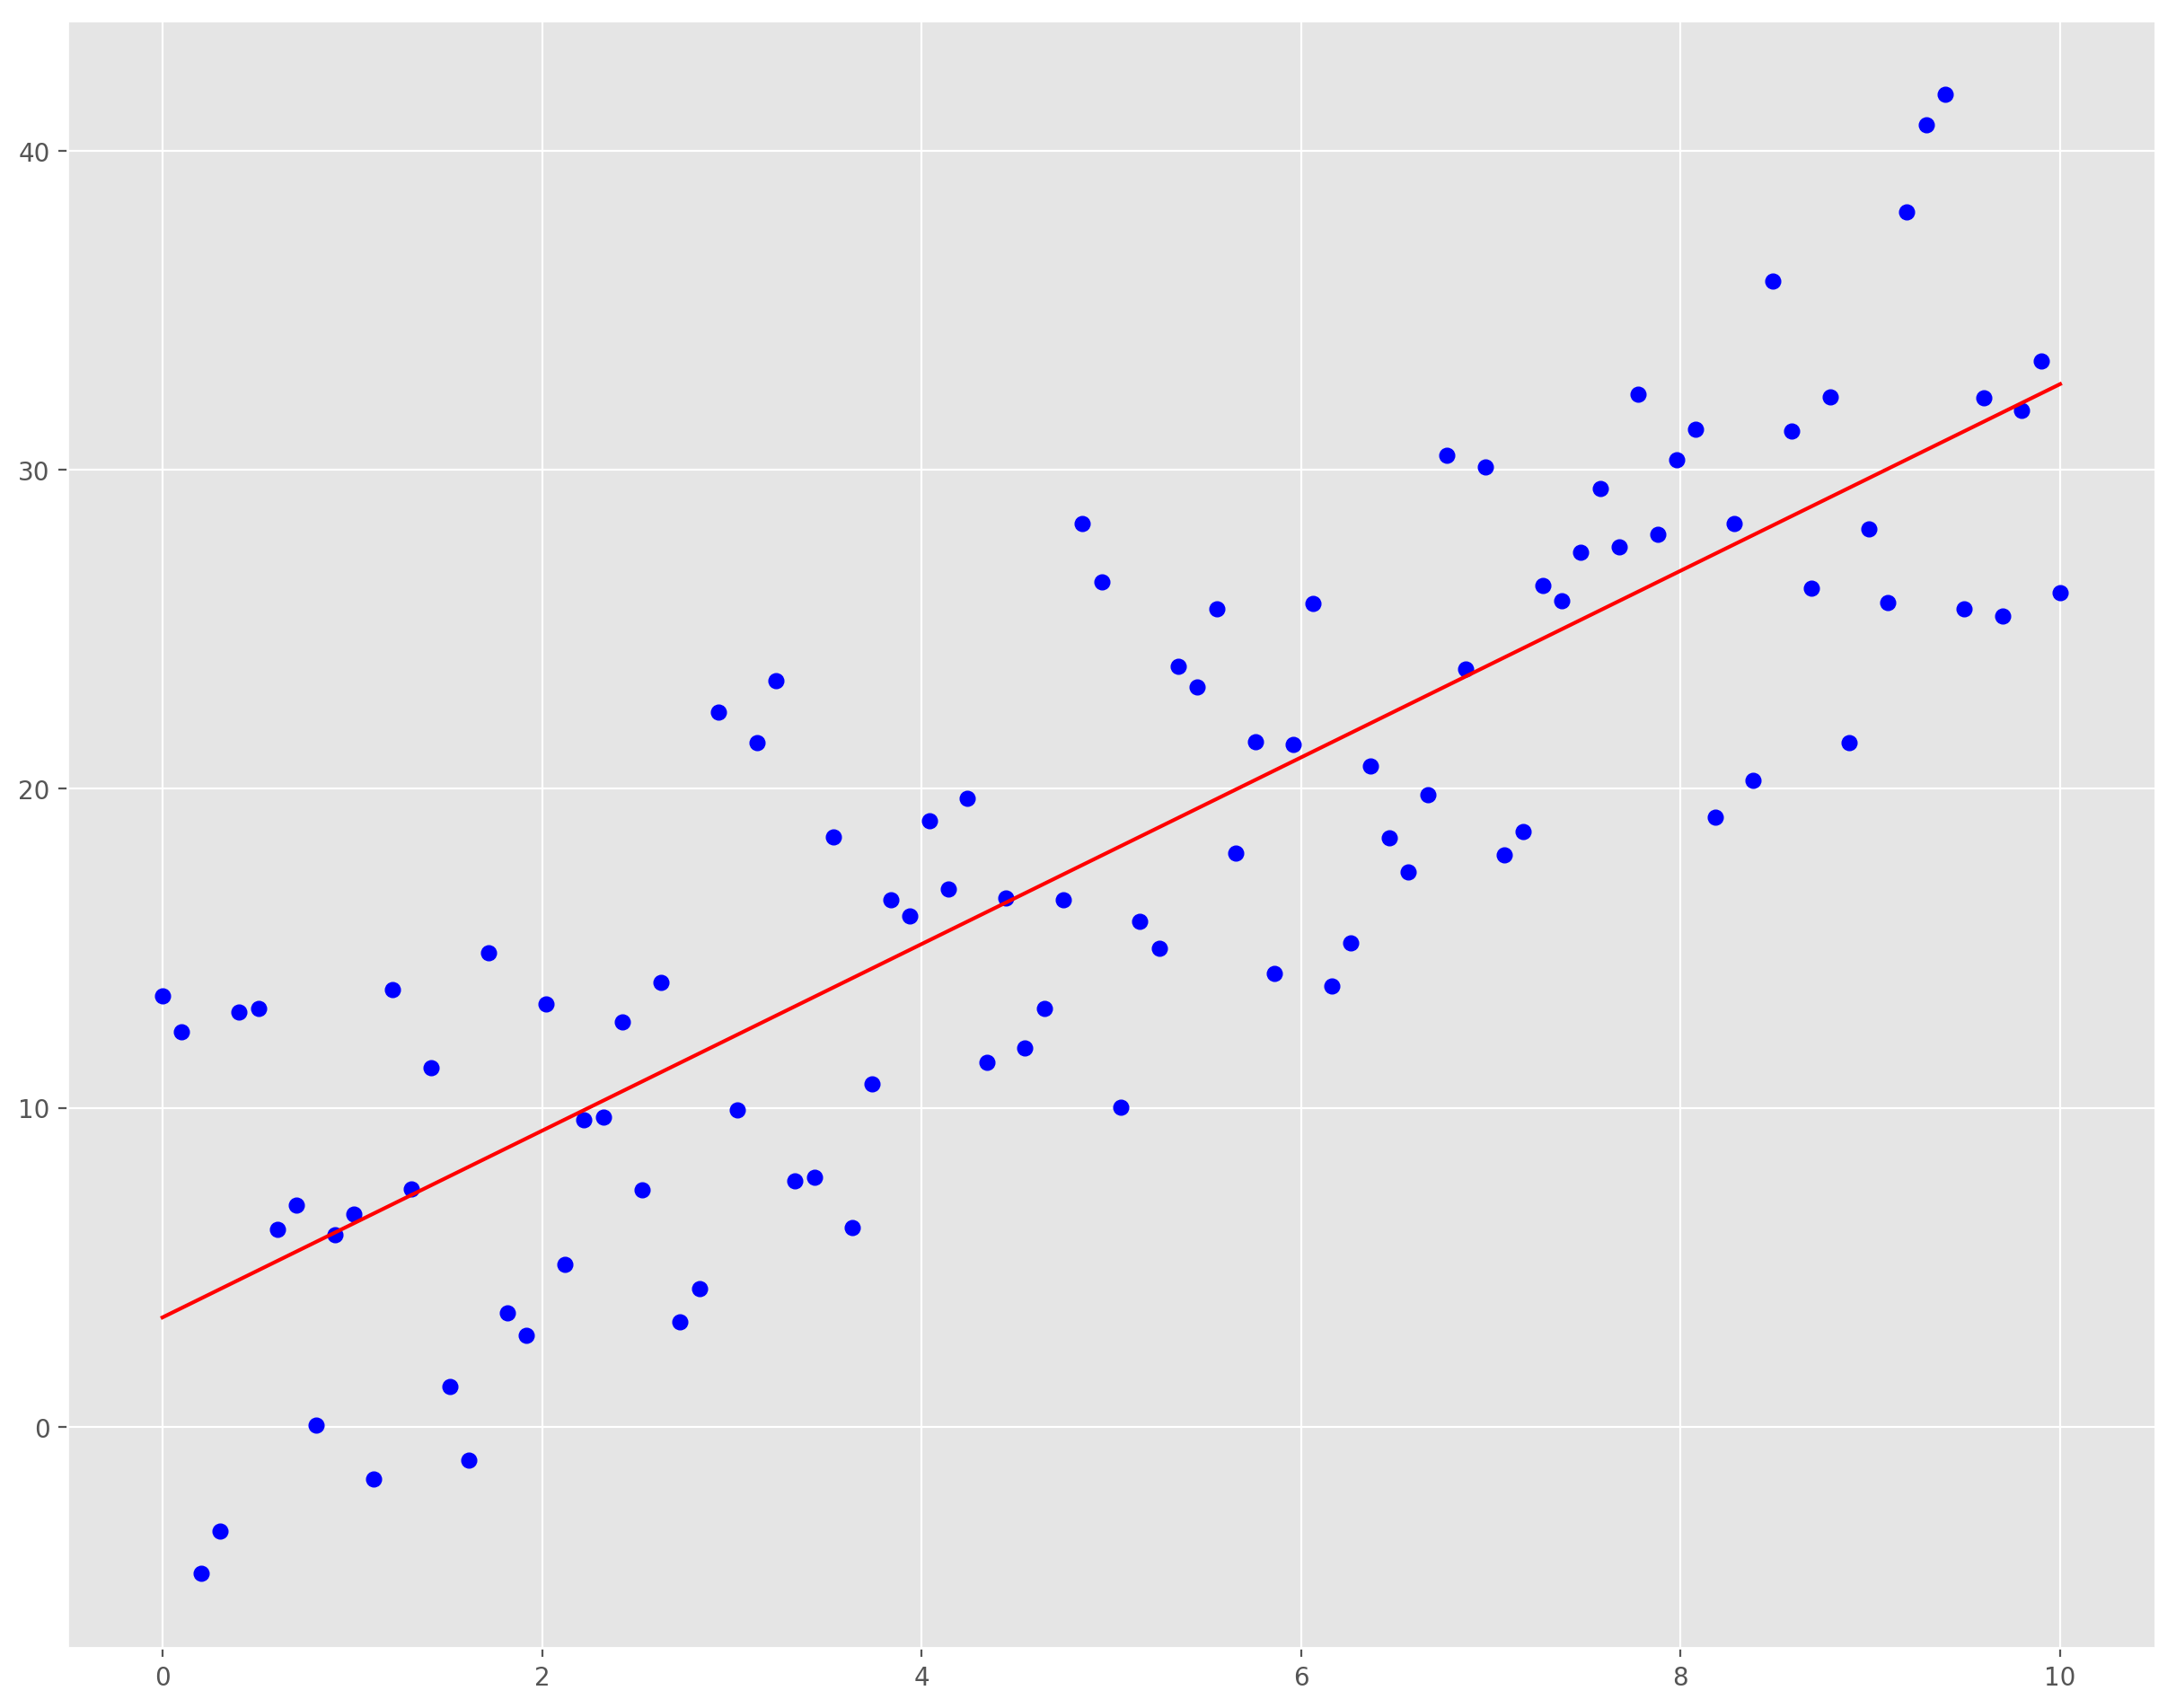

In [20]:
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(x,y,c="b")
plt.plot(x,theta[0]*x+theta[1],c="r")
plt.show();

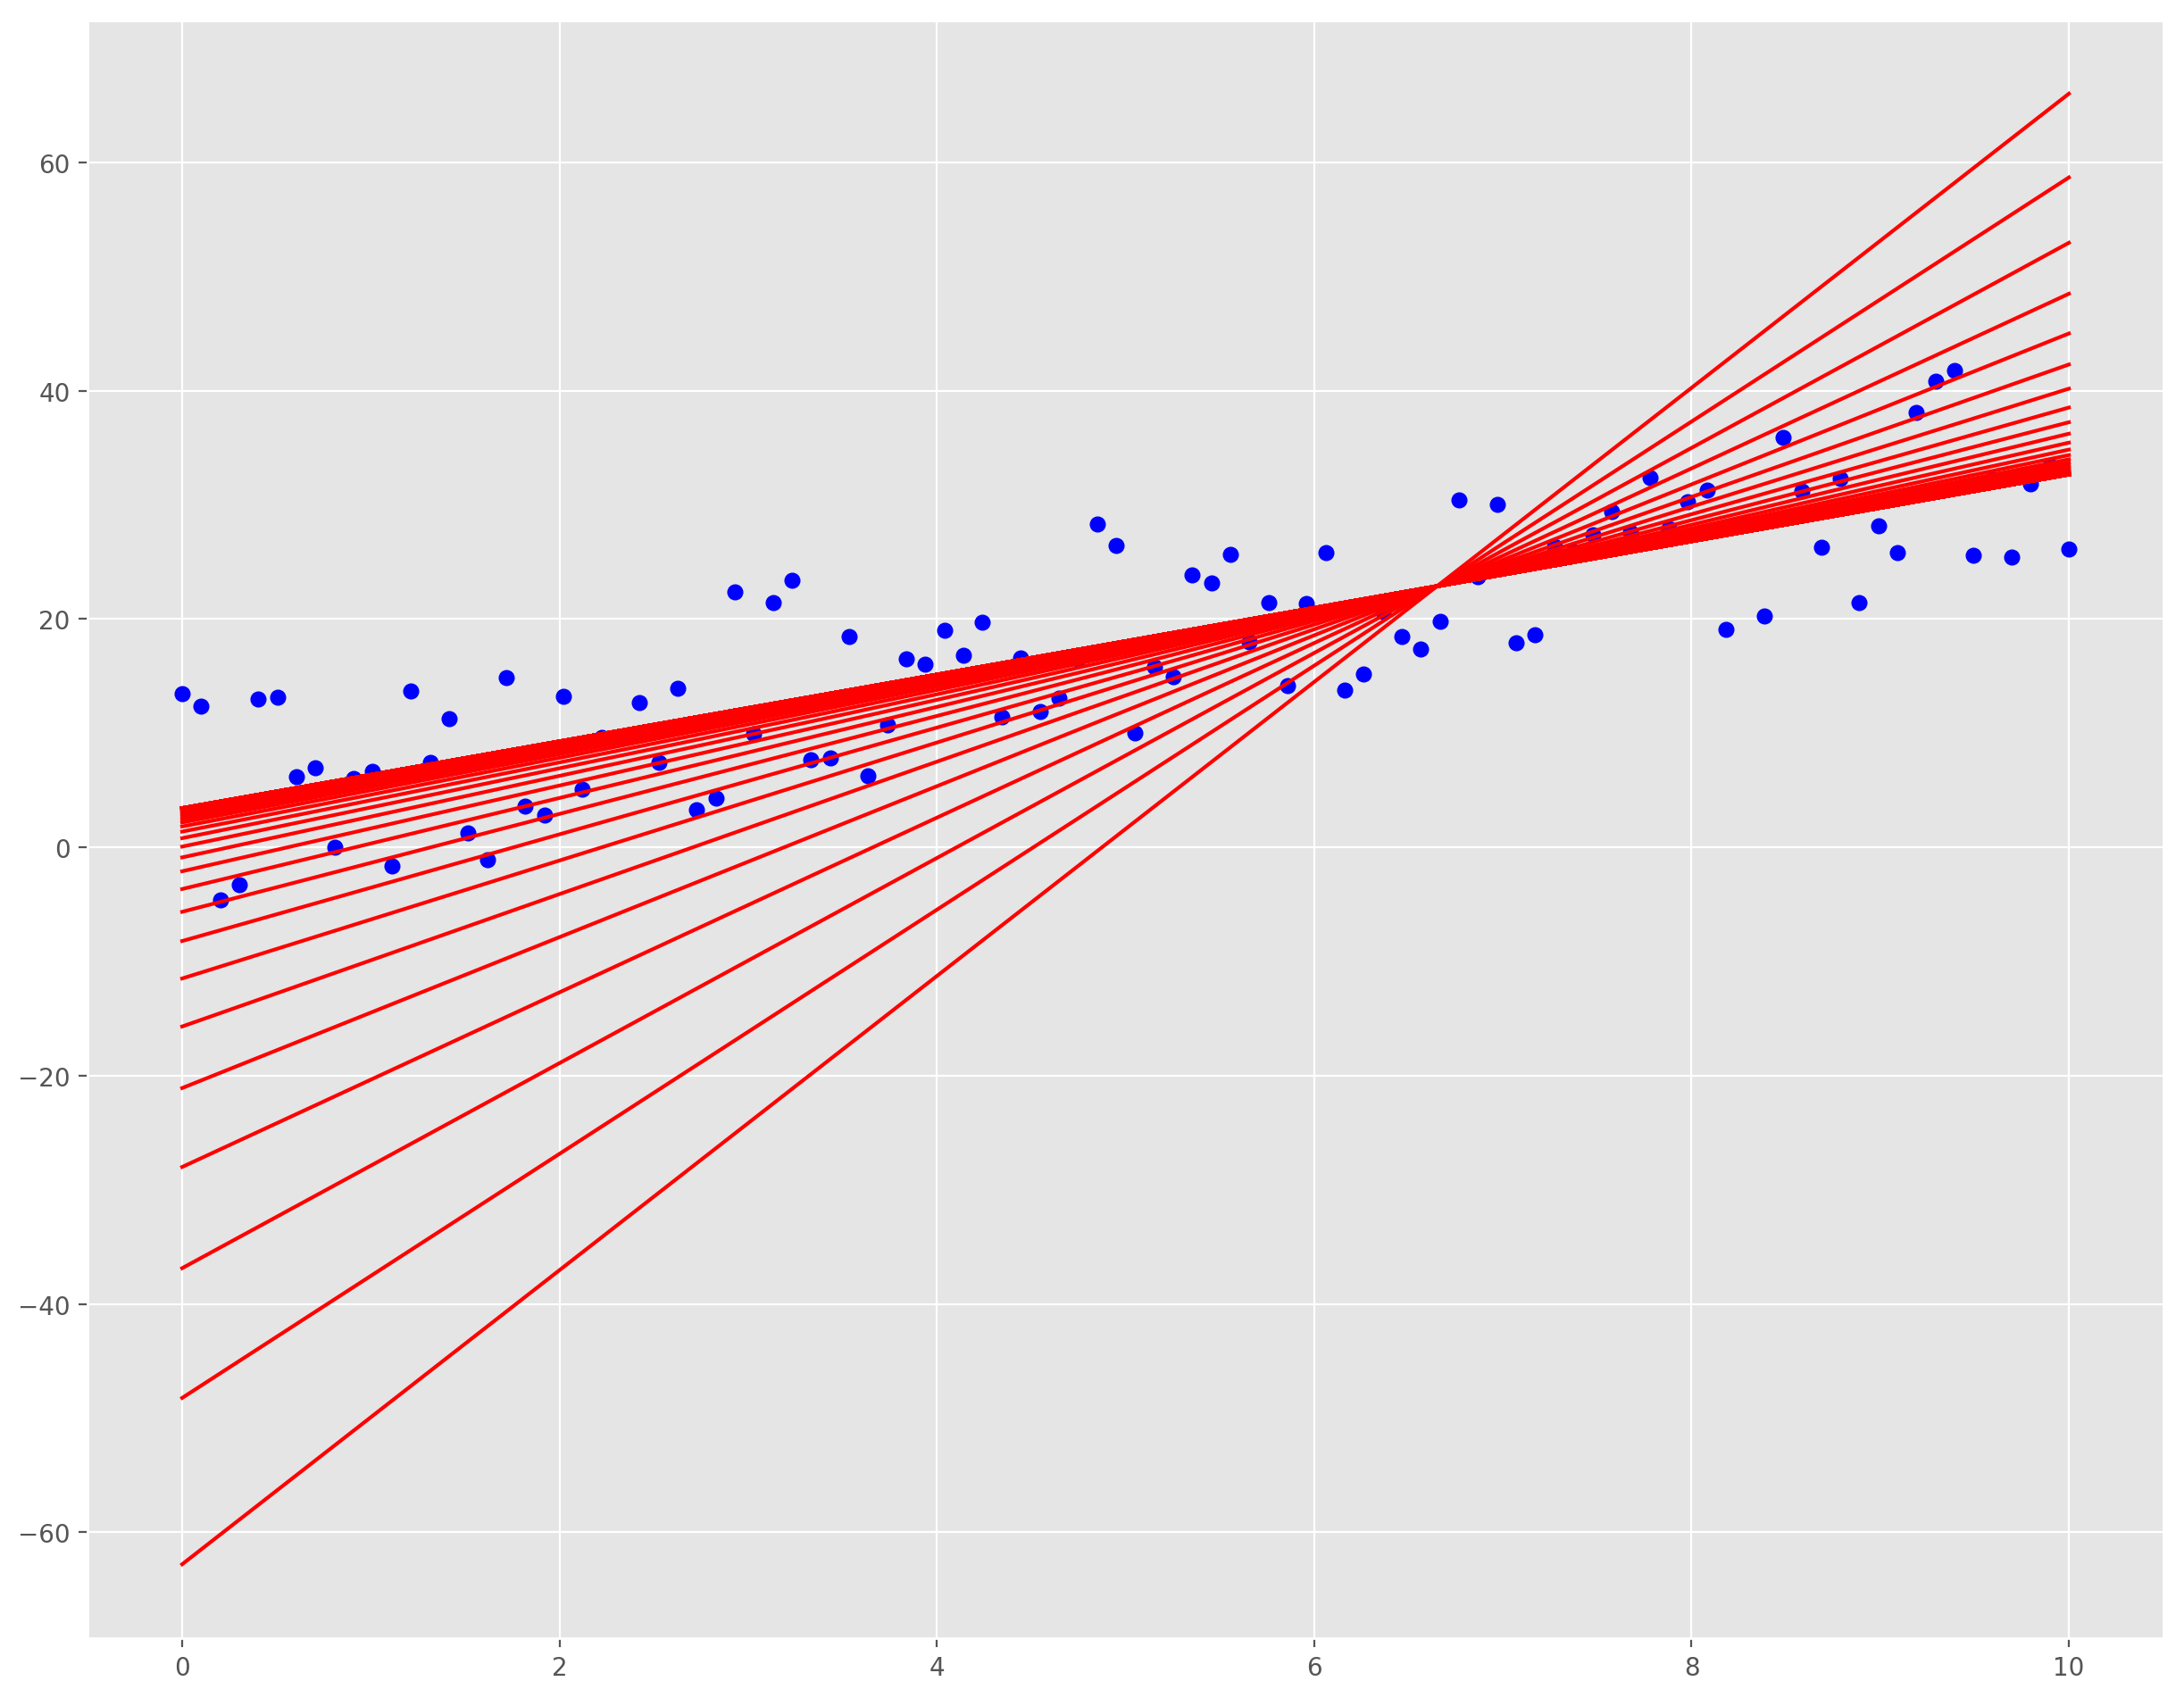

In [21]:
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(x,y,c="b")
for theta in th[[i for i in range(0,10000,100)]][1:]:
    plt.plot(x,theta[0]*x+theta[1],c="r")
plt.show();

So we can use Gradient Descent method also known as steepest descent to find our solutions in ML models.

## Boosting Machines

https://en.wikipedia.org/wiki/Gradient_boosting

**Informal introduction + Algorithm Box**

### Tree Boosting from scratch

So we want to know the pseudo-residuals:
$$ r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x)=F_{m-1}(x)} \quad \mbox{for } i=1,\ldots,n $$
And since
$$ L = Loss = MSE = \sum_{i=1}^{n} (y_i - F_m(x_i))^2 $$
$$ \frac{\partial \sum_{i=1}^{n} (y_i - F_m(x_i))^2}{\partial F_m(x_i)} = -2\times \sum_{i=1}^{n} (y_i - F_m(x_i))$$
Thus, our residuals minimizing the MSE are:
$$r_{im} = -2\cdot (y_i - F_m(x_i))$$

In [22]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

In [23]:
class BoostingTree():
    def __init__(self,n_estimators=10,kind="clas",max_depth = 3,learning_rate=1):
        self.n_estimators = n_estimators
        self.lr=learning_rate
        self.max_depth = max_depth
        self.kind = kind

        if kind == "clas":
            self.dt = DecisionTreeClassifier # self.dt is a class not an object
        else:
            self.dt = DecisionTreeRegressor
        self.estimators = []
    def train(self,X,y):
        
        if X.ndim == 1:
            X = X.reshape(-1,1)
        
        self.f0 = np.mean(y)
        f0 = np.mean(y)
        res = y-f0
        for i in range(self.n_estimators):
            est = self.dt(max_depth=self.max_depth)
            est.fit(X=X,y=res)
            self.estimators.append(est)
            res = y - (f0+sum([self.lr*e.predict(X) for e in self.estimators]))
    def predict(self,X):
        if X.ndim == 1:
            X = X.reshape(-1,1)        
        return self.f0+sum([self.lr*est.predict(X) for est in self.estimators])

In [24]:
bt = BoostingTree(kind="reg")

In [25]:
bt.train(x,y)

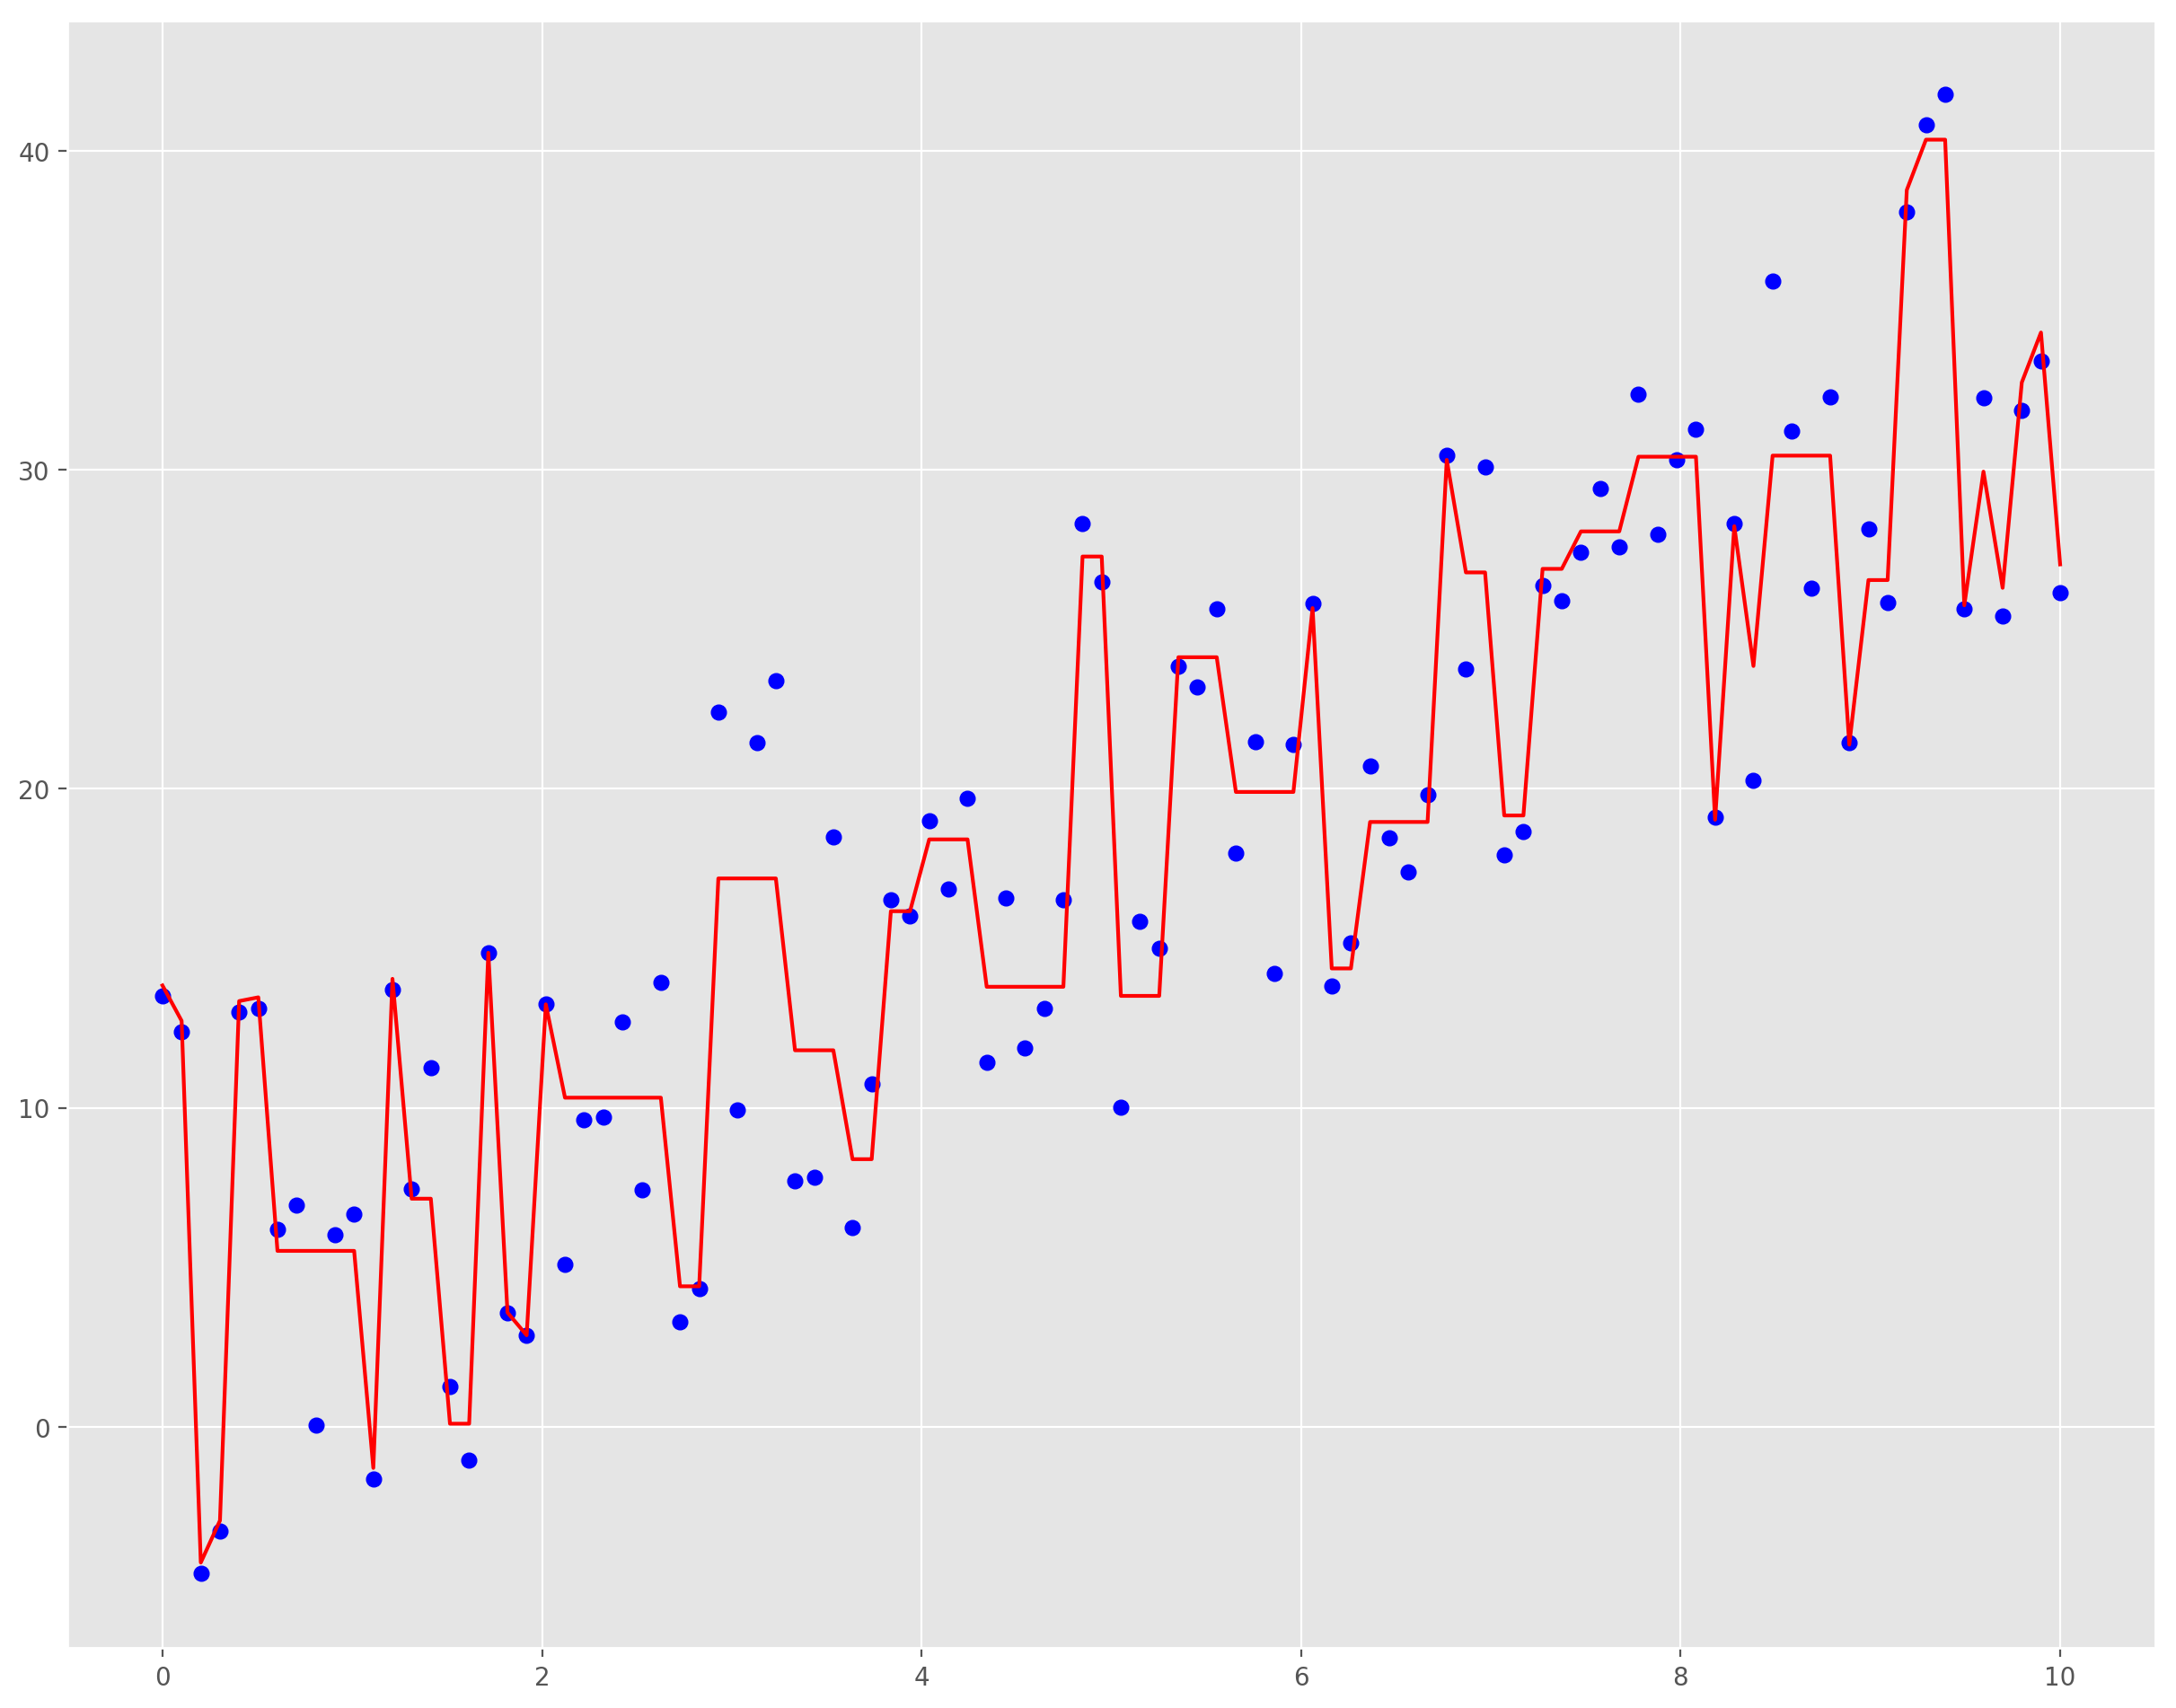

In [26]:
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(x,y,c="b")
plt.plot(x,bt.predict(x),c="r");

This is overfitting... But what about the learning rate in gradient descent?

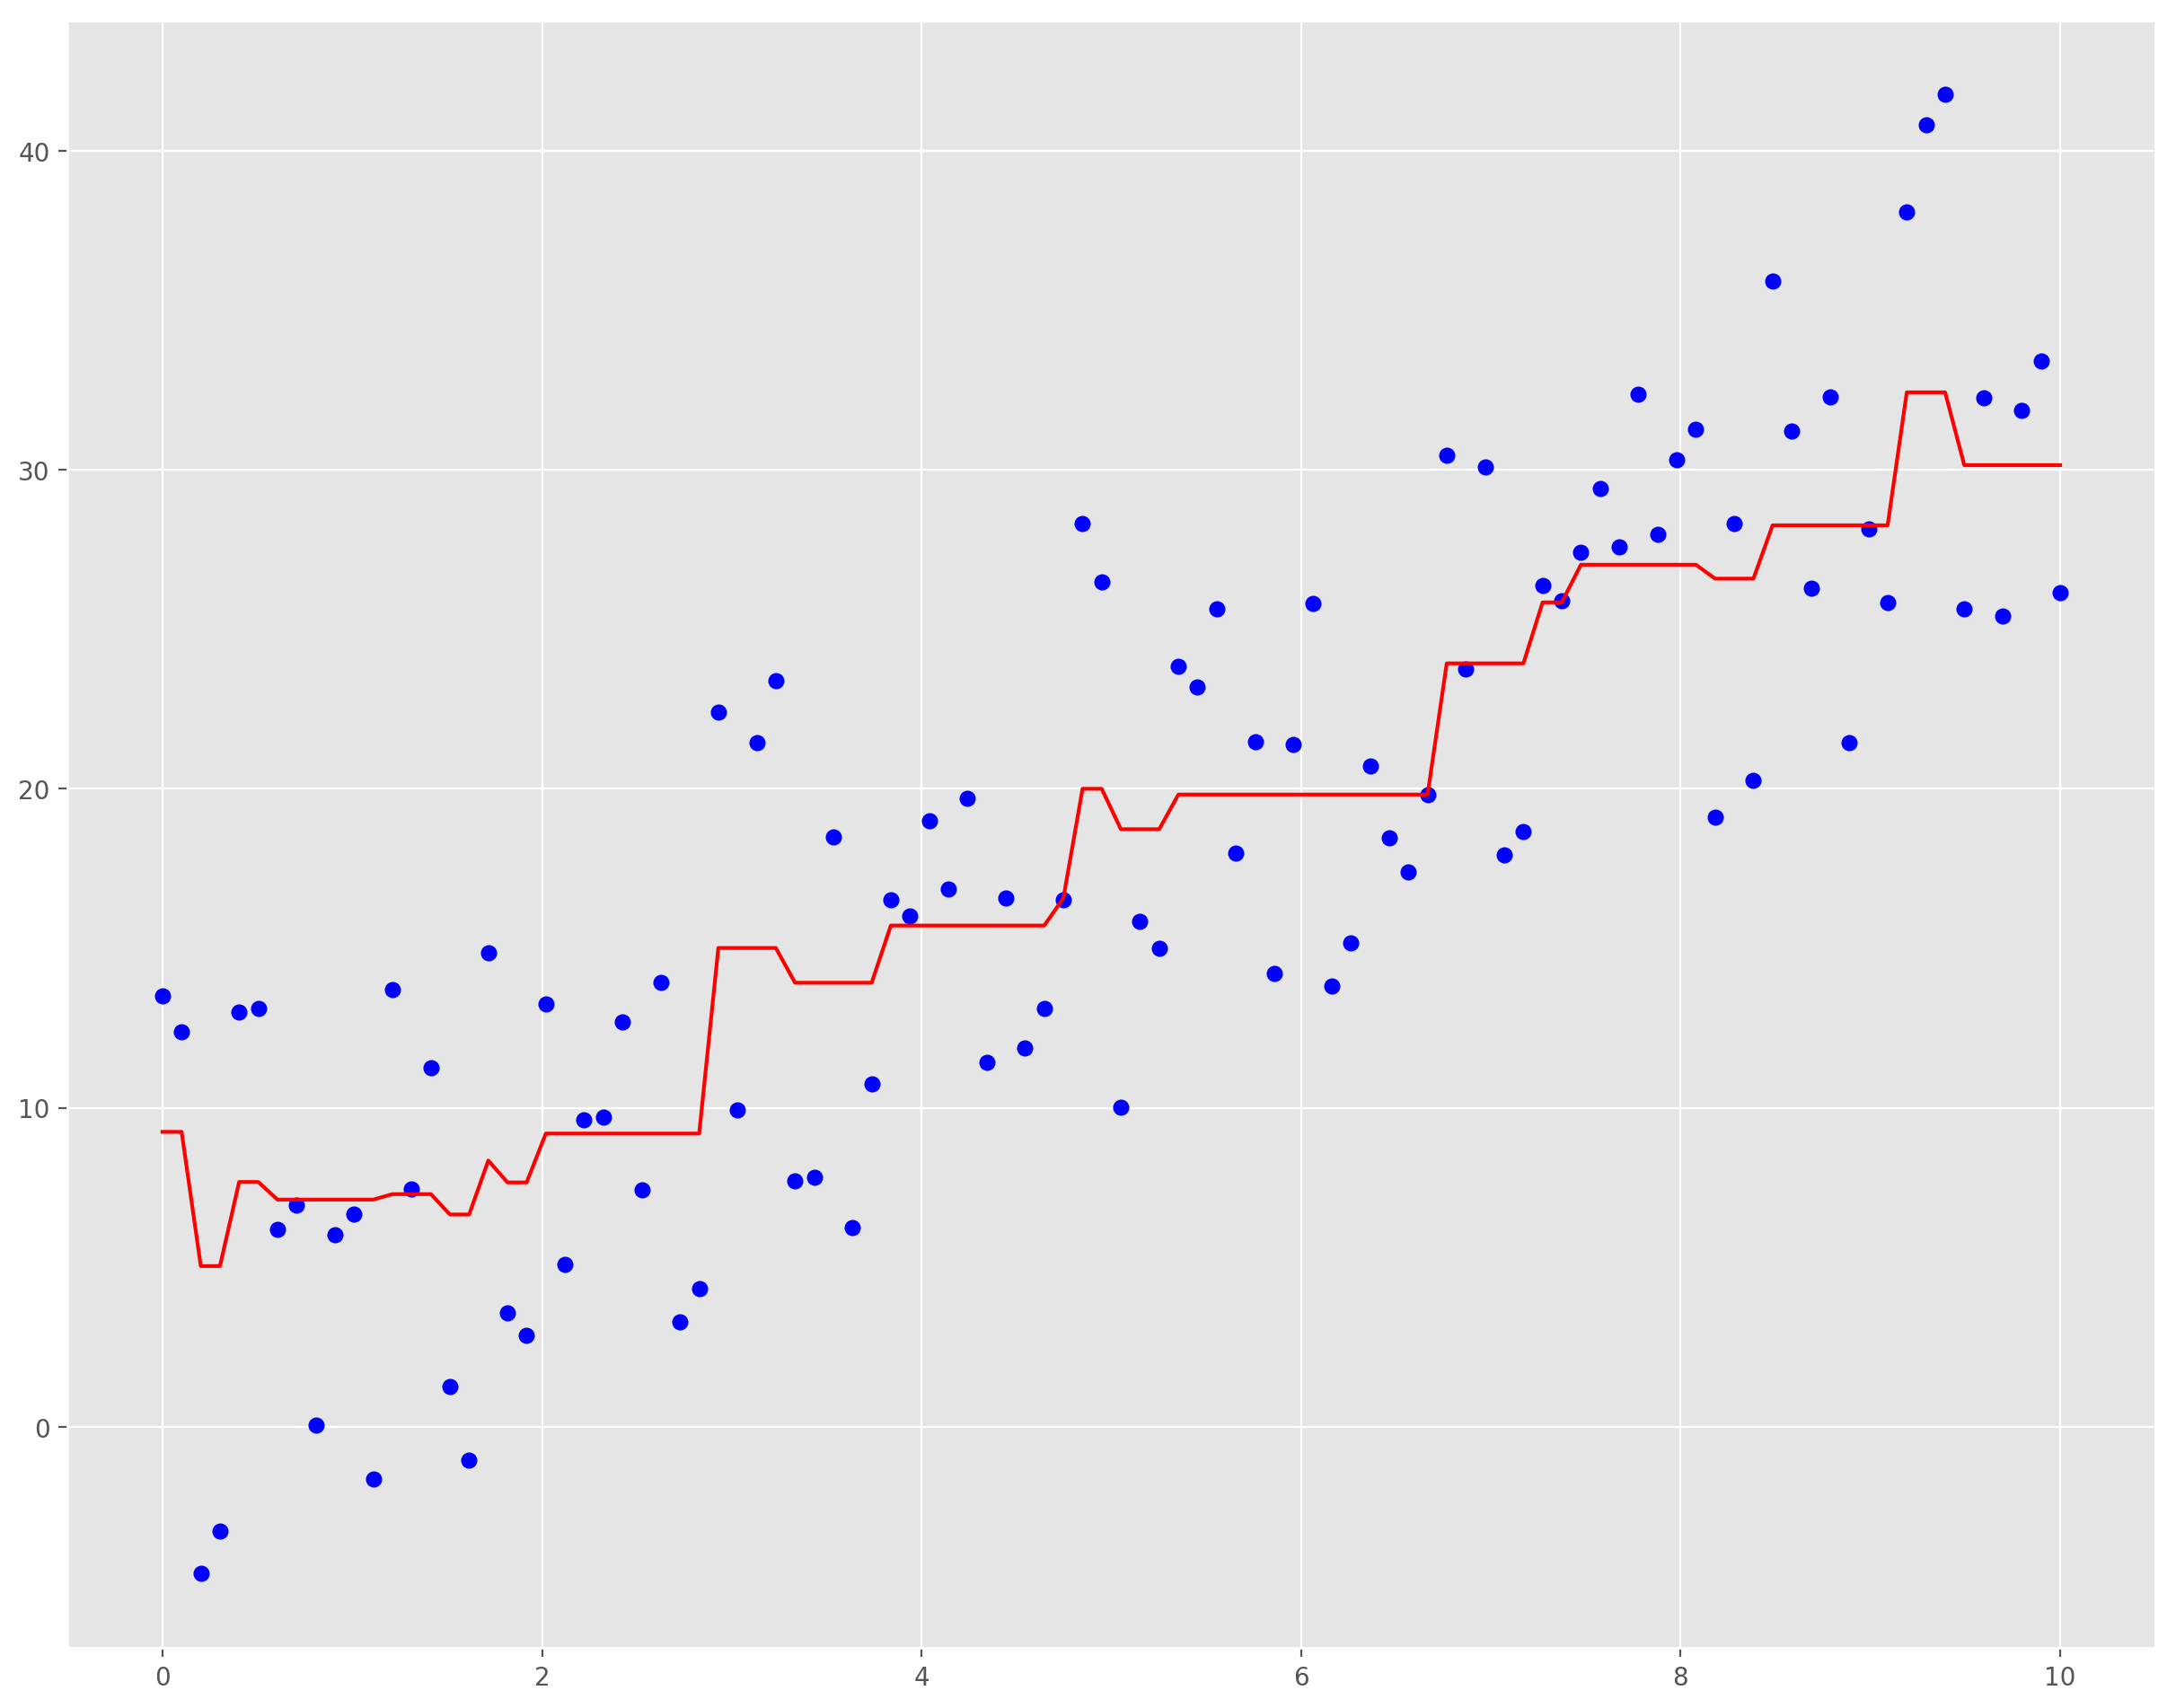

In [27]:
bt = BoostingTree(kind="reg",n_estimators=30,learning_rate=.1,max_depth=2)
bt.train(x,y)
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(x,y,c="b")
plt.plot(x,bt.predict(x),c="r");

We can see that if we want to build a Boosting Tree using MAE instead of MSE, our residuals will be just the $sign(y_i - F_m(x_i))$.

## Sklearn BMs

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

In [29]:
X = x.reshape(-1,1)

In [30]:
bm = GradientBoostingRegressor(loss='ls',
                                n_estimators=20, max_depth=3,
                                learning_rate=.1, max_features="sqrt")
bm.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=20,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [31]:
y_pred = bm.predict(X)

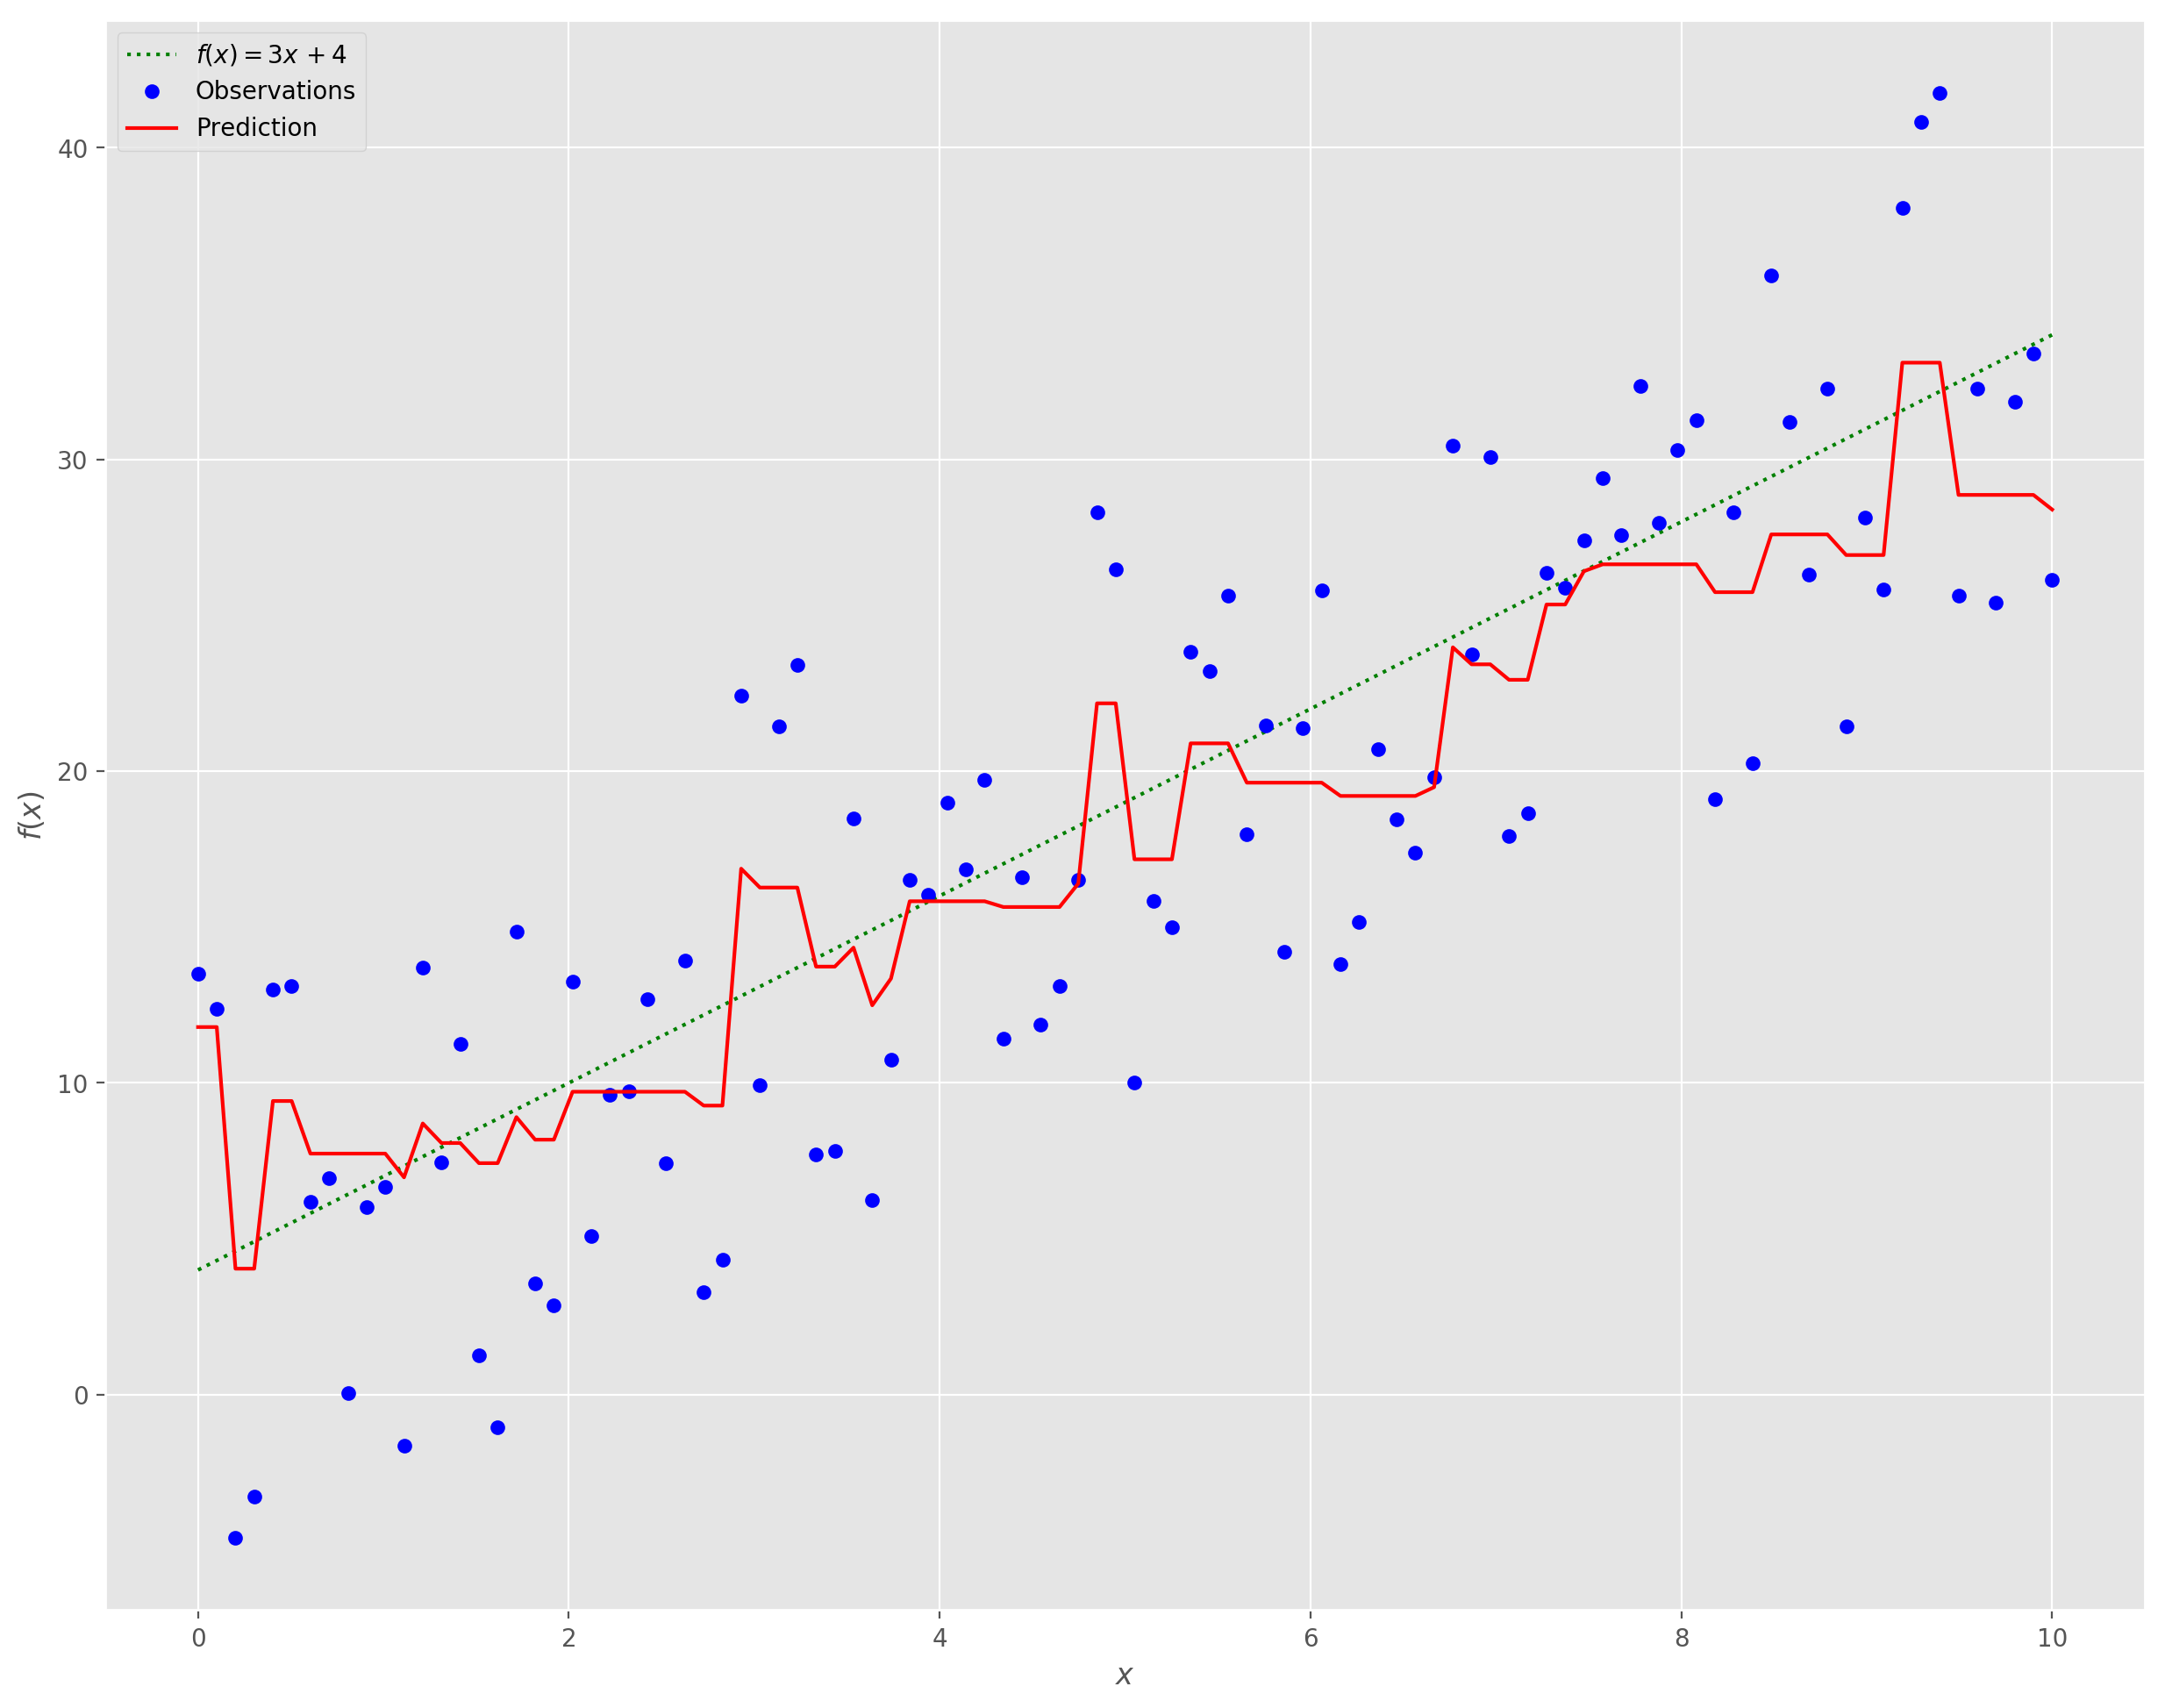

In [32]:
fig = plt.figure(figsize=(15,12),dpi=200)

plt.plot(X, model(X,3,4), 'g:', label=u'$f(x) = 3x\,+4$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(X, y_pred, 'r-', label=u'Prediction')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.legend(loc='upper left')

plt.show()

In [33]:
l_n_estimators = [1,2,3,5,8,12,20]
l_y_pred = []
for n_estimators in l_n_estimators:

    bm = GradientBoostingRegressor(loss='ls',
                                    n_estimators=n_estimators, max_depth=3,
                                    learning_rate=.1, max_features="sqrt")
    bm.fit(X, y)
    l_y_pred.append(bm.predict(X))

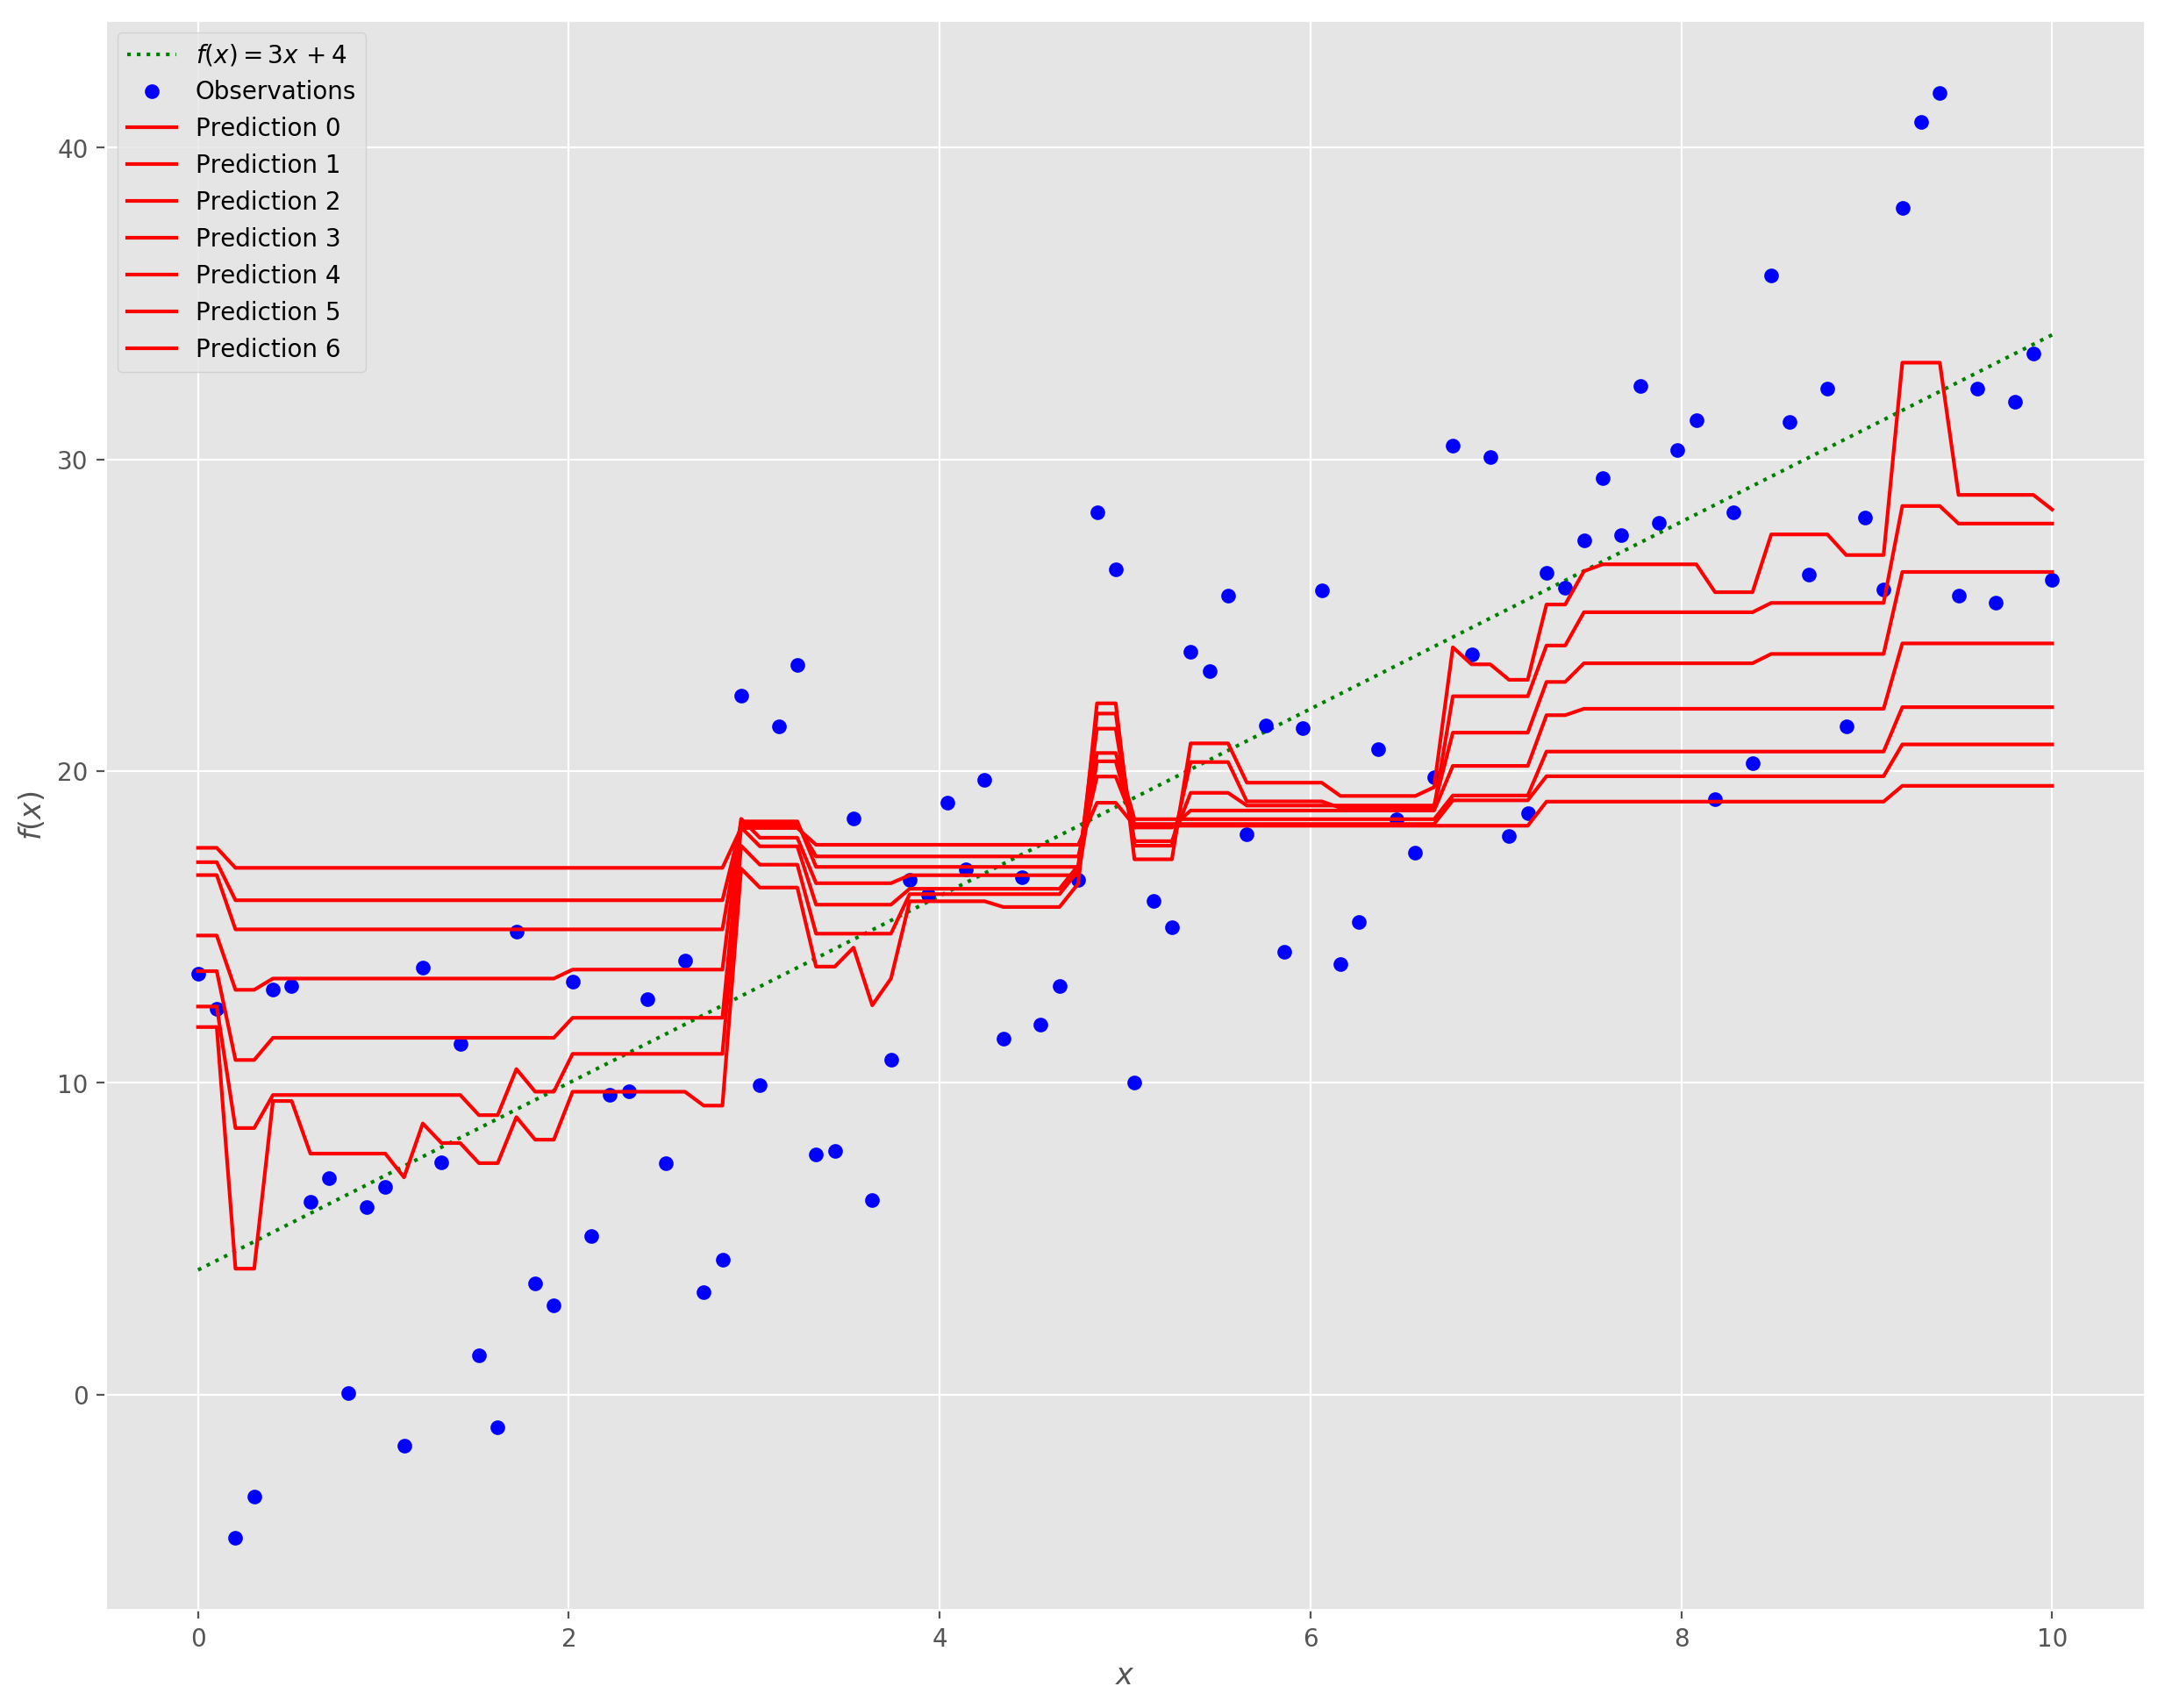

In [34]:
fig = plt.figure(figsize=(15,12),dpi=200)

plt.plot(X, model(X,3,4), 'g:', label=u'$f(x) = 3x\,+4$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')

for i,y_pred in enumerate(l_y_pred):
    plt.plot(X, y_pred, '-r', label=u'Prediction ' + str(i))

plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.legend(loc='upper left')

plt.show()

### Classifier

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets

In [36]:
X,y = datasets.make_circles(n_samples=1000, factor=.6, noise=.1)

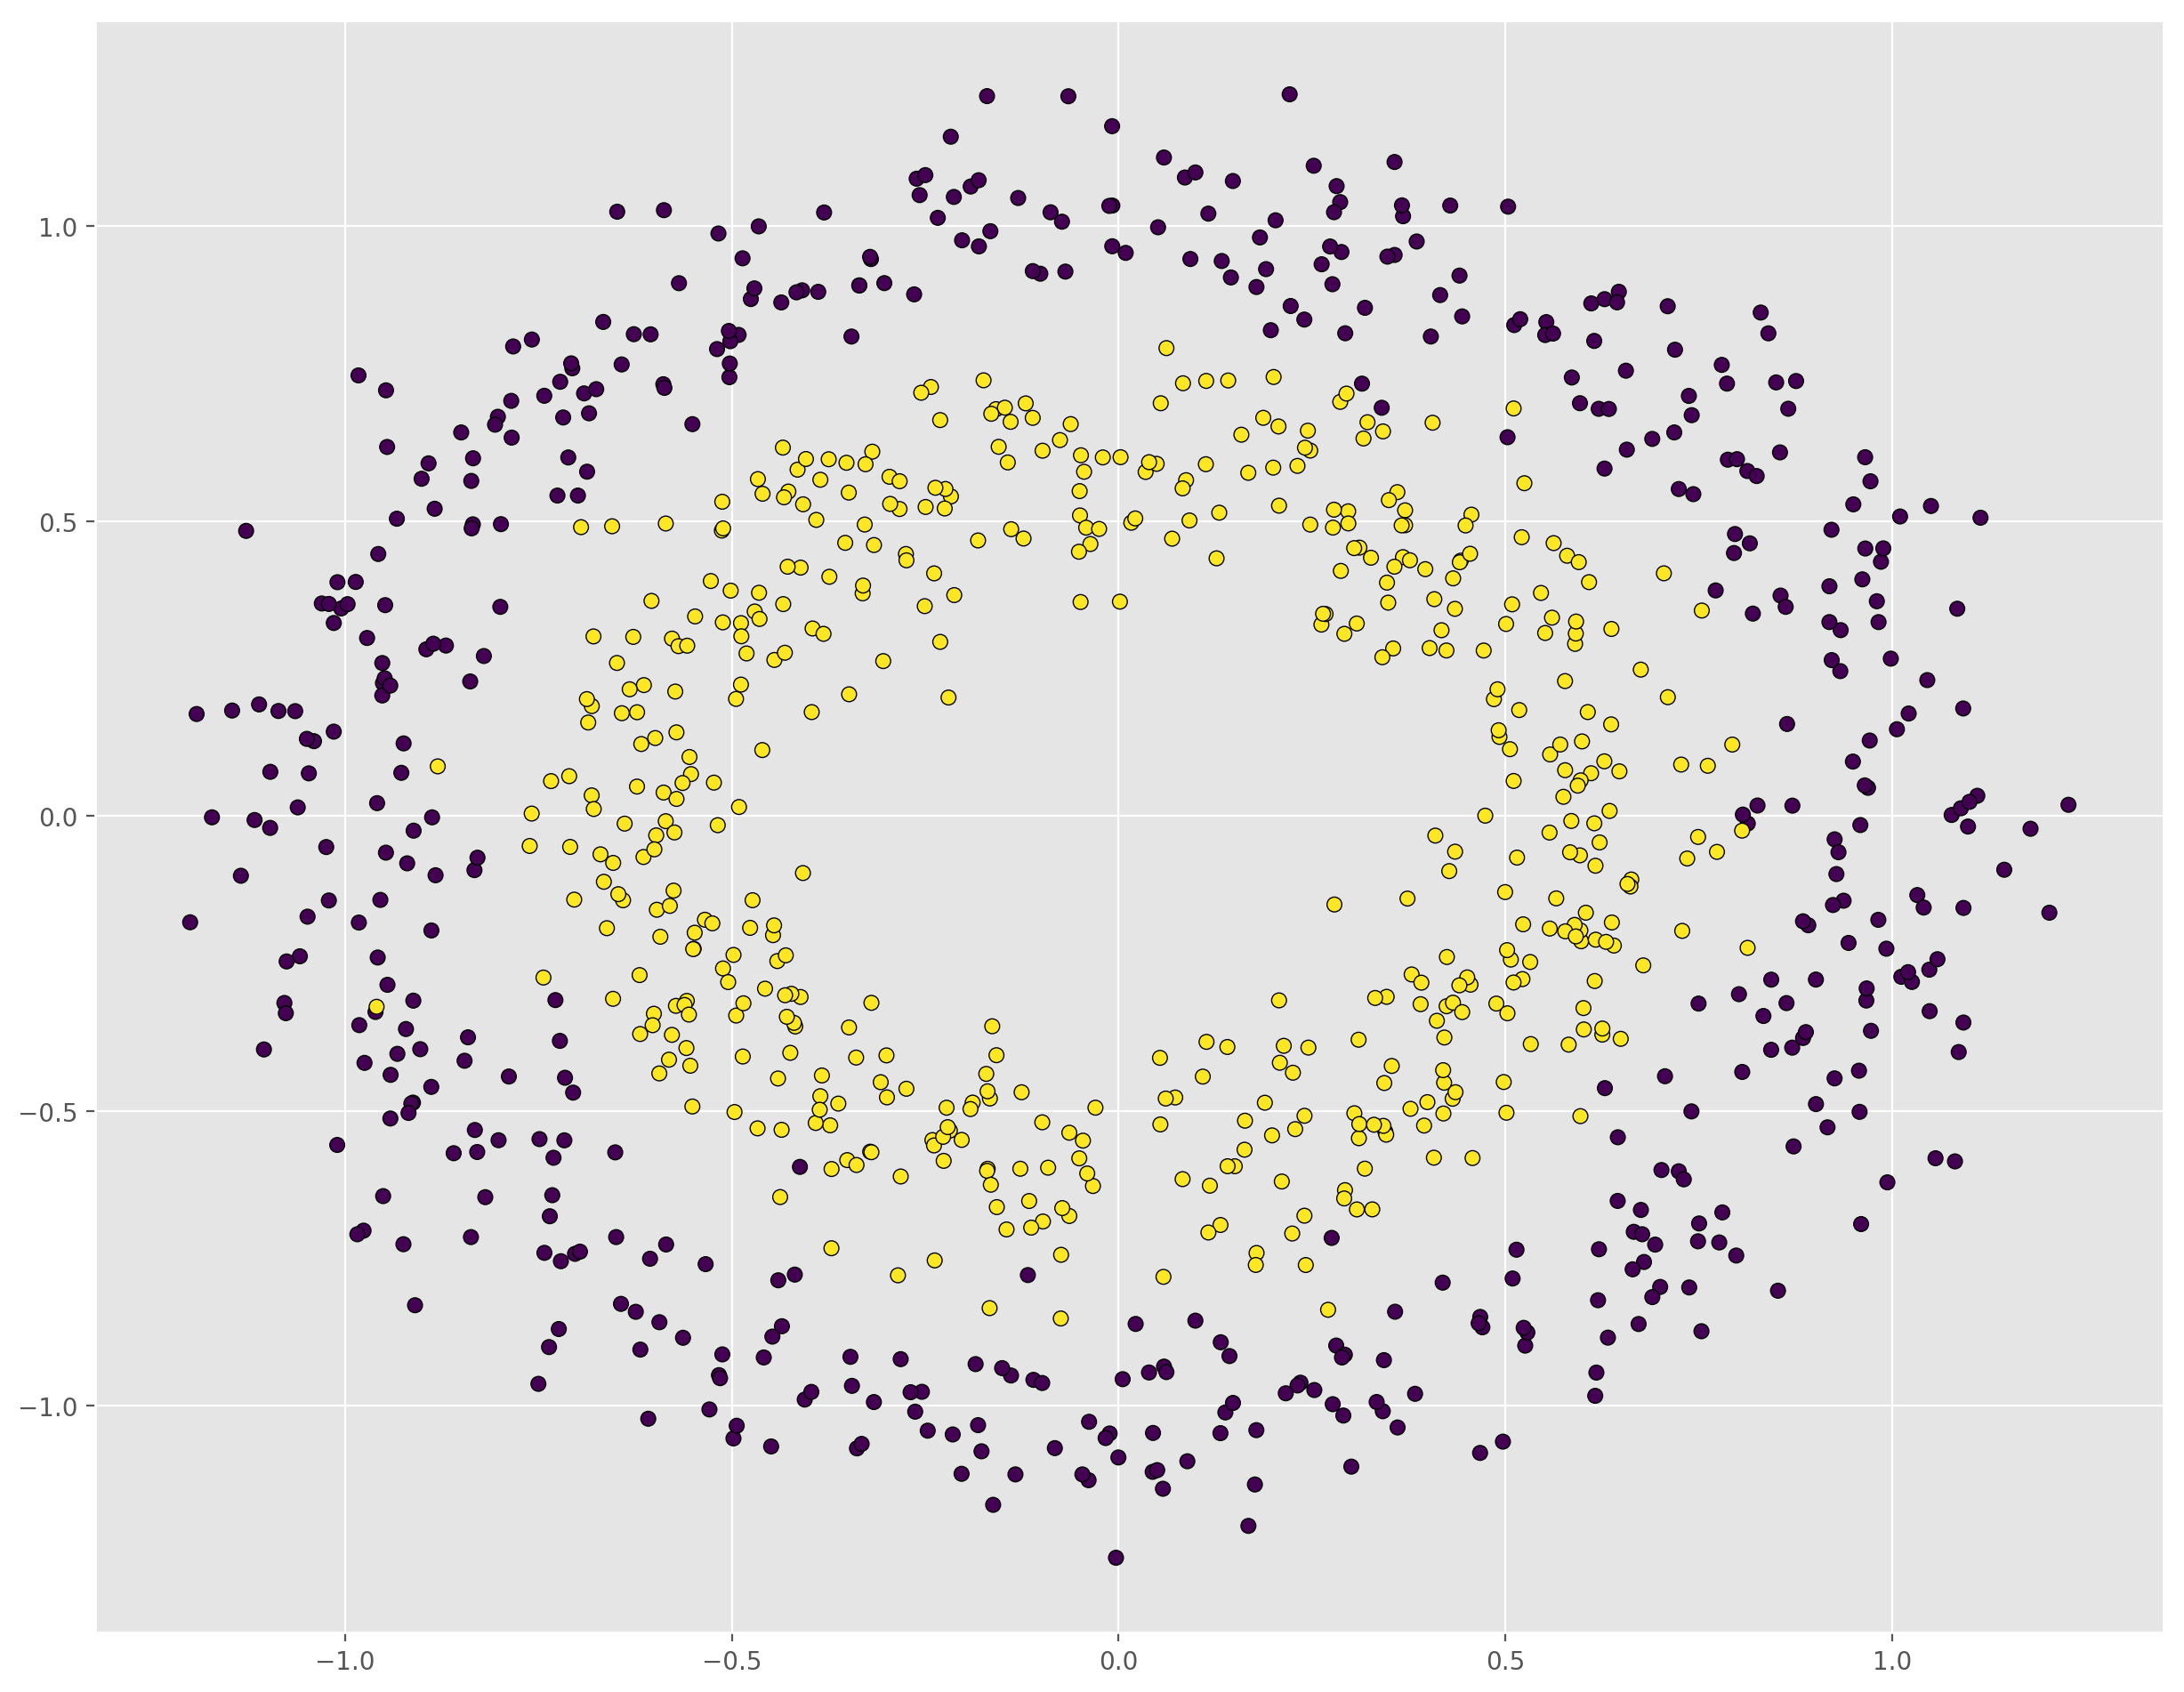

In [37]:
fig = plt.figure(figsize=(15,12),dpi=200)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.show()

In [38]:
bm_c = GradientBoostingClassifier(n_estimators=50)

In [39]:
bm_c.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

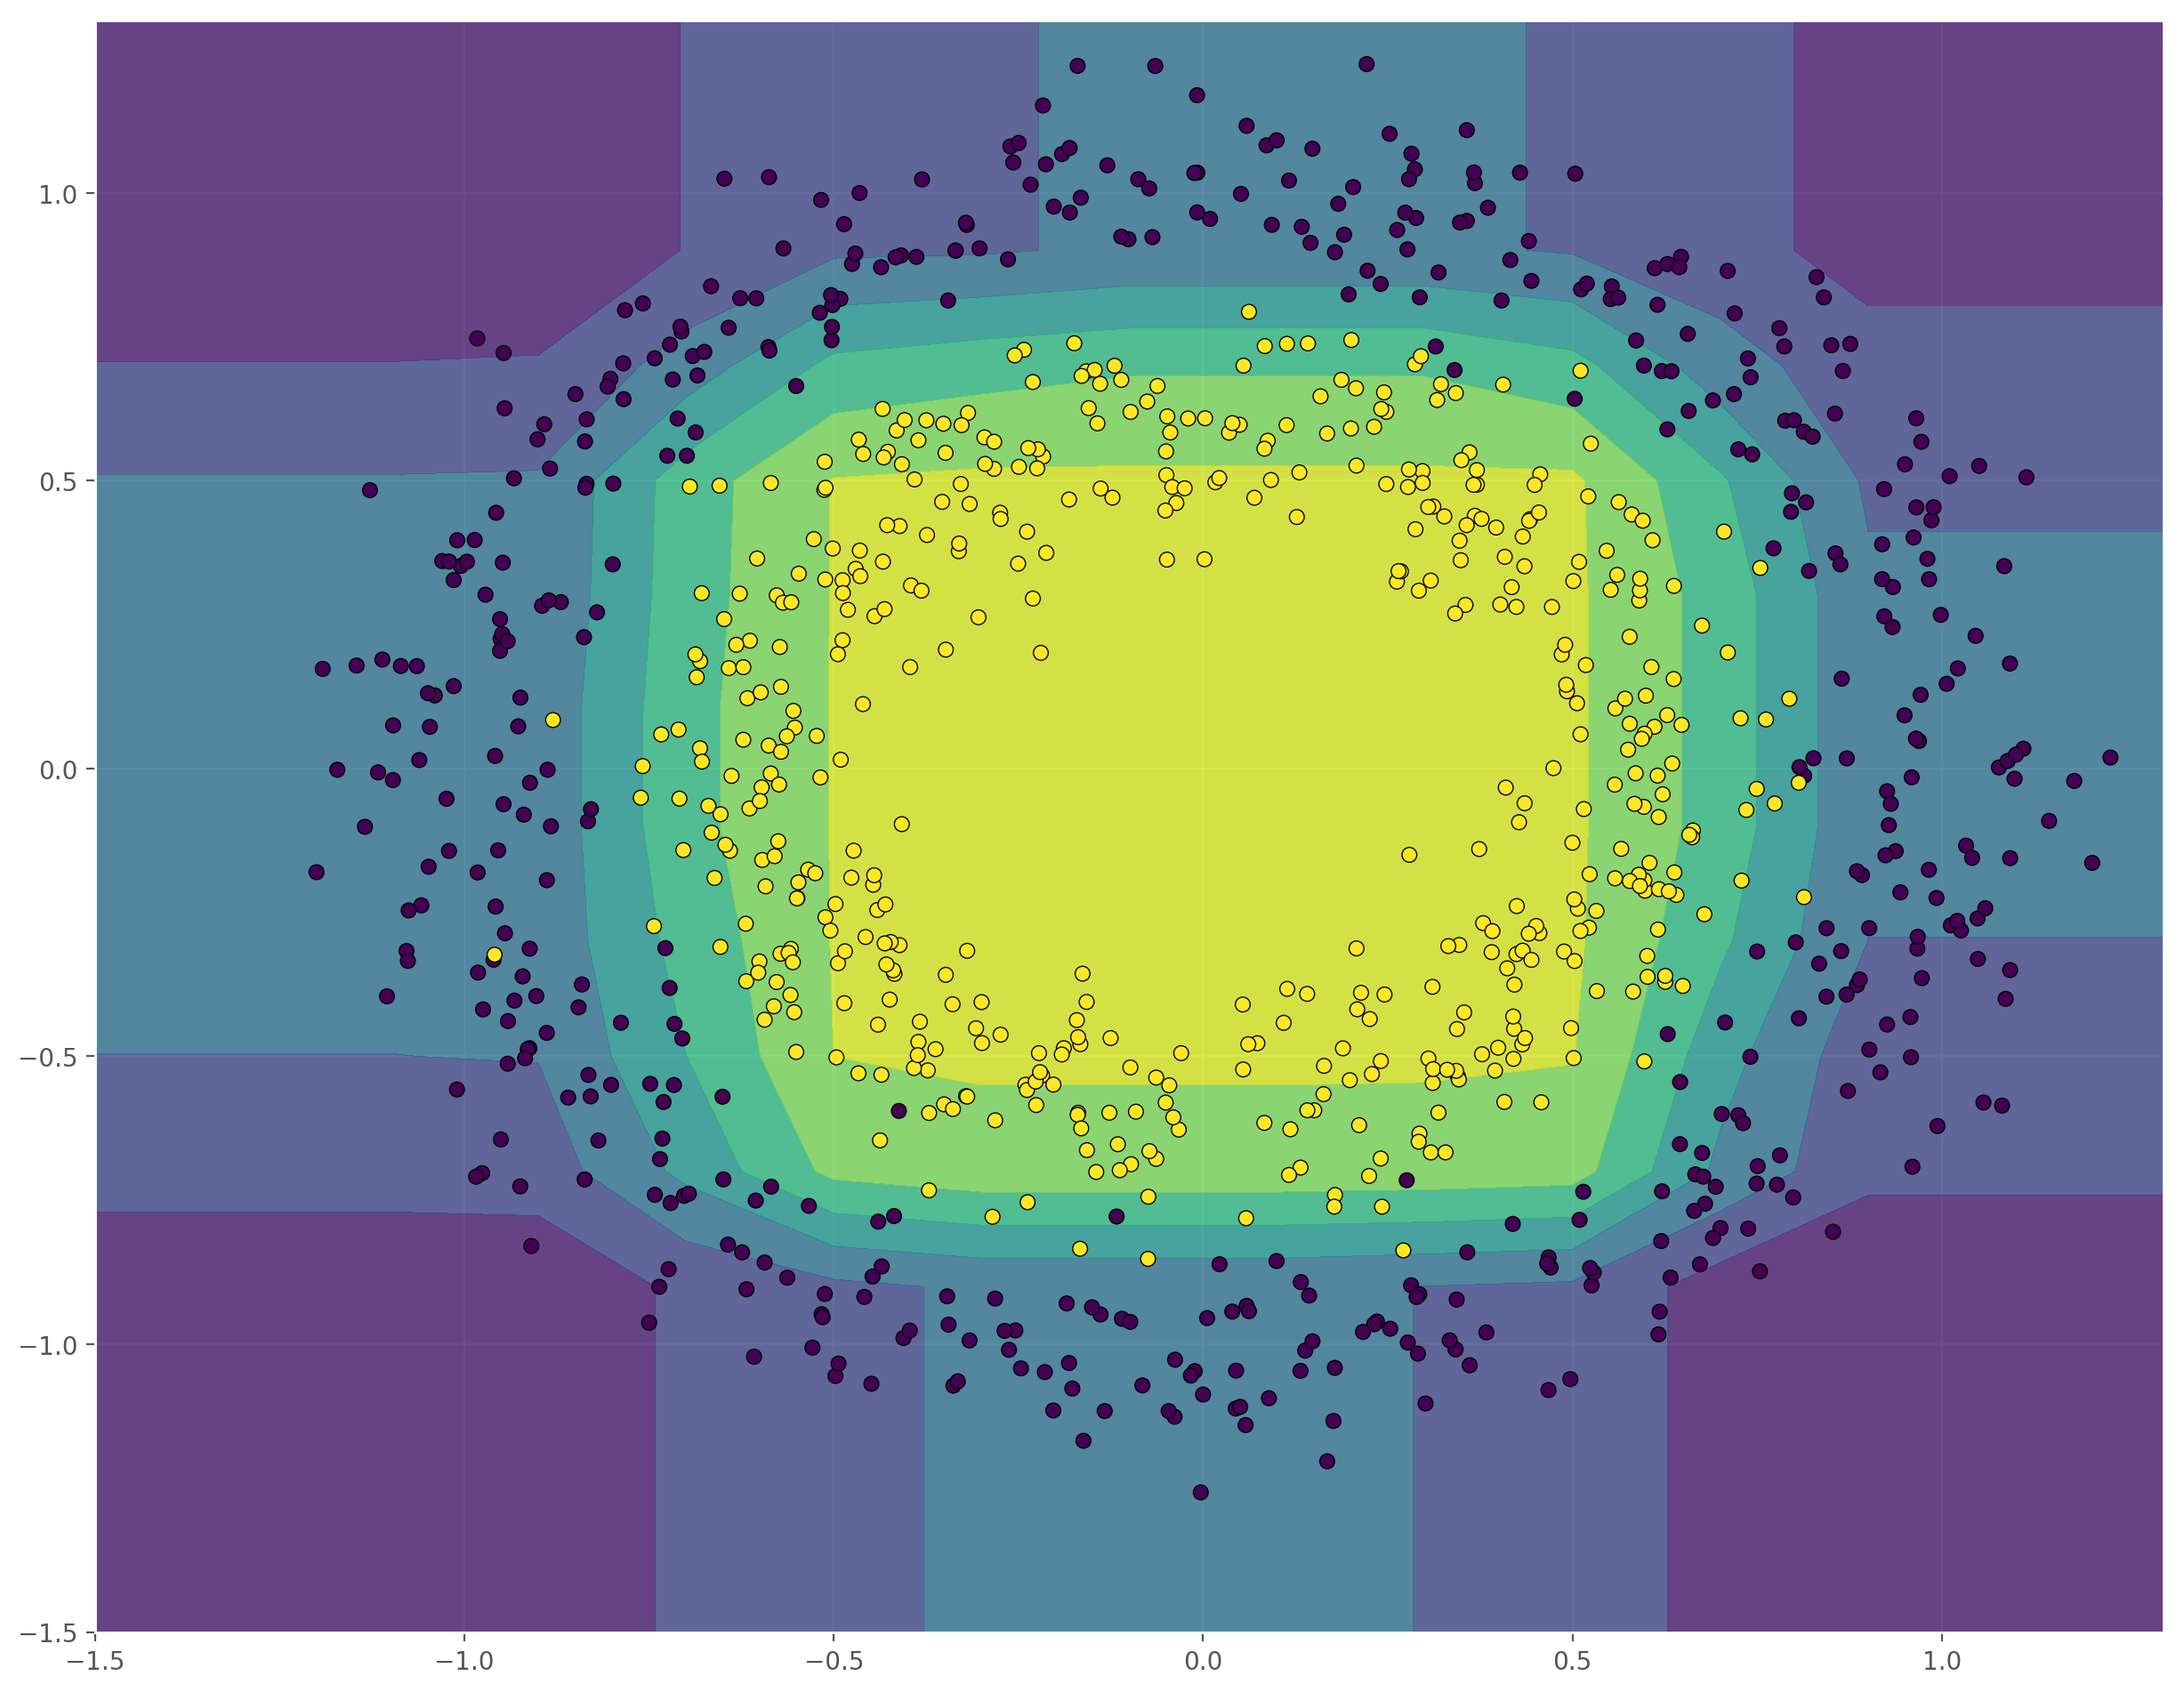

In [40]:
mesh_step_size = 0.2 
xx, yy = np.meshgrid( np.arange(-1.5, 1.5, mesh_step_size), np.arange(-1.5, 1.5, mesh_step_size))
Z = bm_c.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize=(15,12),dpi=200)

plt.contourf(xx, yy, Z, alpha=.8)
plt.scatter(X[:, 0], X[:, 1], c=y,
           edgecolors='k')

plt.show()

## Adults dataset

In [41]:
import pandas as pd

In [42]:
#! pip install --upgrade pandas

In [43]:
df_train = pd.read_feather(path="data/adult_train.f",nthreads=None)
df_test = pd.read_feather(path="data/adult_test.f",nthreads=None)
del df_train["fnlwgt"]
del df_test["fnlwgt"]

In [44]:
df_train.head()

age  workclass  education  education-num  marital-status  occupation  \
0   39          8         10             13               5           2   
1   50          7         10             13               3           5   
2   38          5         12              9               1           7   
3   53          5          2              7               3           7   
4   28          5         10             13               3          11   

   relationship  race  sex  capital-gain  capital-loss  hours-per-week  \
0             2     5    2          2174             0              40   
1             1     5    2             0             0              13   
2             2     5    2             0             0              40   
3             1     3    2             0             0              40   
4             6     3    1             0             0              40   

   native-country  label  
0              40      0  
1              40      0  
2              40      0  
3              40      0  
4               6      0

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train.drop("label",axis=1), 
                                                    df_train["label"], 
                                                    test_size=0.30, 
                                                    random_state=2)

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.2,
    max_depth=4)

In [47]:
clf.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [48]:
clf.score(X_train,y_train),clf.score(X_val,y_val)

(0.8893032643032643, 0.8684614597195209)

In [49]:
1-clf.score(df_test.drop("label",axis=1),df_test["label"])

0.12812480805847304

## `xgboost`

In [50]:
! pip install xgboost

You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [51]:
from xgboost import XGBClassifier

In [52]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=4)

In [53]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [54]:
model.score(X_train,y_train),model.score(X_val,y_val)

(0.8931203931203932, 0.8692803767018119)

In [55]:
1-model.score(df_test.drop("label",axis=1),df_test["label"])

0.12744917388366805

<span style="color:blue">**In-class**: Try to achieve lower error rate tuning parameters and in general playing with titanic dataset. Try to use also PDP plots and permutation tests to see if it helps. </span>